In [24]:
# Cell 0 — Setup (seed, paths, savefig)
# -------------------------------------
# What:
# Initialize the analysis environment with reproducibility seed, directory structure, and helper functions.
#
# Why:
# Guarantees reproducible results, organizes outputs, and standardizes figure saving for inline display and disk storage.
#
# How:
# - Set random seed (1337).
# - Create paths for inputs, processed data, and figures.
# - Define savefig() so plots render inline and save automatically.
#
# Outputs:
# - Directories created: data/inputs/, data/processed/nb2_heterogeneity/, figures/nb2_heterogeneity/.
# - savefig() helper function loaded for downstream cells.
# - Console confirmation that setup is complete.


%matplotlib inline

import os
import json
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try Scanpy import
try:
    import scanpy as sc
    _HAVE_SCANPY = True
except Exception as e:
    _HAVE_SCANPY = False
    print("Warning: scanpy not available yet.", e)

# -----------------------
# Reproducibility
# -----------------------
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)

if _HAVE_SCANPY:
    sc.settings.verbosity = 3
    sc.set_figure_params(dpi=100, dpi_save=300, facecolor="white")

plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300

# -----------------------
# Paths
# -----------------------
PROJECT_ROOT = os.getcwd()
FIG_DIR = os.path.join(PROJECT_ROOT, "figures", "nb2_heterogeneity")
PROC_DIR = os.path.join(PROJECT_ROOT, "data", "processed", "nb2_heterogeneity")
INPUT_DIR = os.path.join(PROJECT_ROOT, "data", "inputs")
CFG_PATH = os.path.join(PROJECT_ROOT, "nb2_run_config.json")

for d in (FIG_DIR, PROC_DIR, INPUT_DIR):
    os.makedirs(d, exist_ok=True)

# -----------------------
# Helper: savefig()
# -----------------------
def savefig(fig, filename_stem, subdir="", ext="png", tight=True):
    ## Render inline and save to disk (auto-creates all parent dirs)
    out_dir = os.path.join(FIG_DIR, subdir)
    # NEW: build full path then ensure its parent exists
    out_path = os.path.join(out_dir, f"{filename_stem}.{ext}")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    fig.savefig(out_path, bbox_inches="tight" if tight else None)
    print(f"[savefig] Saved → {os.path.relpath(out_path)}")


# -----------------------
# Session info
# -----------------------
session_info = {
    "notebook": "Notebook 2 — Organoid Heterogeneity",
    "project": "Organoid-Data-Analysis",
    "created": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "seed": SEED,
    "paths": {
        "figures": os.path.relpath(FIG_DIR),
        "processed": os.path.relpath(PROC_DIR),
        "inputs": os.path.relpath(INPUT_DIR),
        "config": os.path.relpath(CFG_PATH),
    },
    "scanpy_available": _HAVE_SCANPY,
}

print("Cell 0 setup complete.")
print(json.dumps(session_info, indent=2))


Cell 0 setup complete.
{
  "notebook": "Notebook 2 \u2014 Organoid Heterogeneity",
  "project": "Organoid-Data-Analysis",
  "created": "2025-09-27 11:39:41",
  "seed": 1337,
  "paths": {
    "figures": "figures/nb2_heterogeneity",
    "processed": "data/processed/nb2_heterogeneity",
    "inputs": "data/inputs",
    "config": "nb2_run_config.json"
  },
  "scanpy_available": true
}


In [47]:
# Cell 1 — Load dense table (.txt.gz) with robust orientation, infer organoid_id, save config
# -----------------------------------------------------------------------------------------
# What:
# Load the GSE75140 organoid dataset from a dense text file, correct orientation (cells × genes),
# attach metadata if available, and assign organoid_id labels.
#
# Why:
# Ensures the raw dataset is properly formatted and annotated for downstream single-cell analysis.
# Correct orientation is critical: rows must represent cells and columns must represent genes.
#
# How:
# - Read the dense matrix (.txt.gz).
# - Detect orientation by checking whether rows or columns look like gene symbols.
# - Convert into AnnData object with cells as observations, genes as variables.
# - Merge metadata if available and assign organoid_id from barcodes or metadata.
# - Save both a raw checkpoint (.h5ad) and a run configuration JSON file.
#
# Outputs:
# - AnnData object with cells × genes, organoid_id labels included.
# - Checkpoint: data/processed/nb2_heterogeneity/nb2_raw.h5ad
# - Config: nb2_run_config.json
# - Console summary: number of cells, genes, organoids, and pipeline mode (single vs multi).


import os, re, json
from glob import glob
import numpy as np
import pandas as pd
import anndata as ad

PROJECT_ROOT = os.getcwd()
INPUT_DIR = os.path.join(PROJECT_ROOT, "data", "inputs")
PROC_DIR = os.path.join(PROJECT_ROOT, "data", "processed", "nb2_heterogeneity")
CFG_PATH = os.path.join(PROJECT_ROOT, "nb2_run_config.json")
os.makedirs(PROC_DIR, exist_ok=True)

# ---------- helpers ----------
KNOWN_GENES = set([
    "EPCAM","KRT8","KRT18","KRT19","KRT5","KRT14","KRT7","KRT17",
    "ACTB","GAPDH","RPLP0","RPL3","RPS3","MALAT1","EGR1","LGR5","EPC1"
])

def is_gene_like(name: str) -> bool:
    # Upper-ish, alnum and a few symbols, typical gene token; avoid barcode-y delimiters
    n = str(name)
    if any(d in n for d in ["_", ":", "/"]):  # barcodes often have delimiters
        return False
    if len(n) < 2 or len(n) > 20:
        return False
    # many genes are uppercase; allow digits and hyphen/dot
    return bool(re.fullmatch(r"[A-Za-z0-9\.\-]+", n))

def axis_gene_fraction(index: pd.Index) -> float:
    vals = index.astype(str)
    gene_like = sum(is_gene_like(v) for v in vals)
    # boost if any known genes present
    if any(v.upper() in KNOWN_GENES for v in vals[:1000]):
        gene_like += 0.2 * len(vals)  # small bonus to sway decision
    return gene_like / max(len(vals), 1)

def read_dense(path_txt_gz: str) -> pd.DataFrame:
    df = pd.read_csv(path_txt_gz, sep="\t", header=0, index_col=0)
    # Decide orientation: we want CELLS x GENES
    frac_idx_gene = axis_gene_fraction(df.index)
    frac_col_gene = axis_gene_fraction(df.columns)
    # If index looks like genes and columns don't, transpose
    if frac_idx_gene > 0.6 and frac_col_gene < 0.4:
        df = df.T
        oriented = "transposed (rows=cells, cols=genes)"
    # If columns look like genes and index doesn't, keep as is
    elif frac_col_gene > 0.6 and frac_idx_gene < 0.4:
        oriented = "kept (rows=cells, cols=genes)"
    else:
        # fallback by size: more genes than cells typically → genes should be columns
        oriented = "heuristic fallback"
        if df.shape[0] > df.shape[1]:
            df = df.T
    # coerce numeric
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    print(f"[orientation] {oriented} | shape={df.shape} (cells x genes)")
    return df

def maybe_read_metadata(input_dir: str):
    meta_files = glob(os.path.join(input_dir, "meta_*.tsv")) + \
                 glob(os.path.join(input_dir, "meta_*.csv")) + \
                 glob(os.path.join(input_dir, "*metadata*.tsv")) + \
                 glob(os.path.join(input_dir, "*metadata*.csv"))
    if not meta_files:
        return None, None
    meta_path = sorted(meta_files)[0]
    sep = "\t" if meta_path.endswith(".tsv") else ","
    meta = pd.read_csv(meta_path, sep=sep)
    for cand in ["cell_id","barcode","cell","CellID","Cell","Barcode","NAME","sample","Sample"]:
        if cand in meta.columns:
            meta = meta.set_index(cand)
            break
    else:
        meta = meta.set_index(meta.columns[0])
    meta.index = meta.index.astype(str)
    return meta, meta_path

def infer_organoid_from_barcodes(obs_names: pd.Index) -> pd.Series:
    # Extract first chunk before common delimiters; prefer alnum group with letters+digits
    inferred = []
    for cid in obs_names.astype(str):
        chunk = re.split(r"[_\-\.:]", cid)[0]
        # if chunk looks too generic (e.g., long random), try a letter+digits group
        m = re.search(r"[A-Za-z]+\d+", cid)
        inferred.append(m.group(0) if m else chunk)
    return pd.Series(inferred, index=obs_names.astype(str), name="organoid_id")

# ---------- locate input ----------
preferred = os.path.join(INPUT_DIR, "GSE75140_hOrg.fetal.master.data.frame.txt.gz")
if os.path.exists(preferred):
    chosen = preferred
else:
    txts = sorted(glob(os.path.join(INPUT_DIR, "*.txt.gz")))
    if not txts:
        raise FileNotFoundError("No *.txt.gz found in data/inputs/. Place the dense matrix there.")
    chosen = txts[0]

print(f"[input] Using dense table: {os.path.relpath(chosen)}")
df = read_dense(chosen)  # cells x genes

# ---------- build AnnData ----------
obs = pd.DataFrame(index=df.index.astype(str))
var = pd.DataFrame(index=df.columns.astype(str))
adata = ad.AnnData(X=df.values, obs=obs, var=var)
adata.var_names_make_unique()
adata.obs_names_make_unique()

# ---------- merge metadata if available ----------
meta, meta_path = maybe_read_metadata(INPUT_DIR)
if meta is not None:
    inter = adata.obs_names.intersection(meta.index)
    if len(inter) > 0:
        adata.obs = adata.obs.join(meta.loc[inter], how="left")
        print(f"[meta] Merged metadata: {os.path.relpath(meta_path)} (overlap n={len(inter)})")
    else:
        print(f"[meta] WARNING: No overlap with {os.path.relpath(meta_path)} — skipping merge.")

# ---------- assign organoid_id ----------
organoid_col_candidates = [
    "organoid_id","OrganoidID","organoid","Organoid","sample","Sample",
    "orig.ident","batch","Batch","patient","Patient"
]
for col in organoid_col_candidates:
    if col in adata.obs.columns:
        adata.obs["organoid_id"] = adata.obs[col].astype(str).values
        print(f"[organoid_id] Using column: {col}")
        break
else:
    adata.obs["organoid_id"] = infer_organoid_from_barcodes(adata.obs_names).values
    print("[organoid_id] Inferred from cell IDs (heuristic).")

# ---------- save ----------
raw_ckpt_path = os.path.join(PROC_DIR, "nb2_raw.h5ad")
adata.write(raw_ckpt_path)

org_counts = adata.obs["organoid_id"].value_counts().to_dict()
pipeline_mode = "multi" if len(org_counts) > 1 else "single"

cfg = {
    "notebook": "nb2_heterogeneity",
    "dataset_mode": "real",
    "input_format": "dense_txt",
    "input_detail": os.path.relpath(chosen),
    "metadata_path": (os.path.relpath(meta_path) if meta is not None else None),
    "organoid_label_col": "organoid_id",
    "pipeline_mode": pipeline_mode,
    "raw_checkpoint": os.path.relpath(raw_ckpt_path),
}
with open(CFG_PATH, "w") as f:
    json.dump(cfg, f, indent=2)

print("\n[summary] Dense load complete (fixed orientation).")
print(f"- Cells: {adata.n_obs:,} | Genes: {adata.n_vars:,}")
print(f"- organoid_id levels: {len(org_counts)} → {{k: v for k, v in list(org_counts.items())[:8]}} ...")
print(f"- Pipeline mode: {pipeline_mode}")
print(f"- Raw checkpoint → {os.path.relpath(raw_ckpt_path)}")
print(f"- Config → {os.path.relpath(CFG_PATH)}")
print("Step 1B complete — raw data loaded with correct orientation.")


[input] Using dense table: data/inputs/GSE75140_hOrg.fetal.master.data.frame.txt.gz
[orientation] kept (rows=cells, cols=genes) | shape=(734, 18928) (cells x genes)
[organoid_id] Inferred from cell IDs (heuristic).

[summary] Dense load complete (fixed orientation).
- Cells: 734 | Genes: 18,928
- organoid_id levels: 96 → {k: v for k, v in list(org_counts.items())[:8]} ...
- Pipeline mode: multi
- Raw checkpoint → data/processed/nb2_heterogeneity/nb2_raw.h5ad
- Config → nb2_run_config.json
Step 1B complete — raw data loaded with correct orientation.
Index looks like cells; first 5: ['A10_hOrg_ESC_reg1_53d', 'A12_hOrg_ESC_reg1_53d', 'A3_hOrg_ESC_reg1_53d', 'A4_hOrg_ESC_reg1_53d', 'A6_hOrg_ESC_reg1_53d']
Var looks like genes; first 5: ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2']
Unique organoid_id (n): 96
C12    10
G9     10
B10    10
E3     10
F3      9
E2      9
C7      9
G7      9
D4      9
B11     9
Name: organoid_id, dtype: int64
Total cells: 734 | Genes: 18928


In [ ]:
# Interpretation — Cell 1 (Data load, orientation, organoid_id)
# -------------------------------------------------------------
# The dataset includes 734 cells across ~18,900 genes, with 96 organoids represented.
# Each cell is now linked to an organoid_id, allowing us to analyze replicate-level variability.
#
# Biological meaning:
# - These organoids are cerebral organoids derived from pluripotent stem cells (Camp et al. 2015).
# - Each organoid should contain mixtures of neural progenitors (e.g., SOX2+, PAX6+),
#   intermediate progenitors (EOMES/TBR2+), and neurons (DCX+, MAP2+).
# - The presence of many organoids means we can assess how consistently these lineages
#   are generated across replicates.
#
# Implications for heterogeneity:
# - With ~96 organoids, we expect variation in the proportions of progenitors vs neurons,
#   as observed in the original study (organoids often underrepresented in basal progenitors).
# - The small number of cells sampled per organoid means differences will manifest
#   more as shifts in cell-type balance than as organoid-specific new states.
#
# Guidance:
# - Interpret heterogeneity primarily at the level of composition and diversity of known lineages.
# - Later steps will reveal whether organoids reliably capture the expected cortical hierarchy
#   or if some organoids deviate in their balance of progenitors and neurons.


[savefig] Saved → figures/nb2_heterogeneity/qc/qc_pass_histograms.png
[savefig] Saved → figures/nb2_heterogeneity/qc/qc_pass_scatter.png
[summary] QC-pass complete (no filtering).
- Cells: 734 | Genes: 18928 | MT genes detected: 0
- QC checkpoint saved → data/processed/nb2_heterogeneity/nb2_qc.h5ad


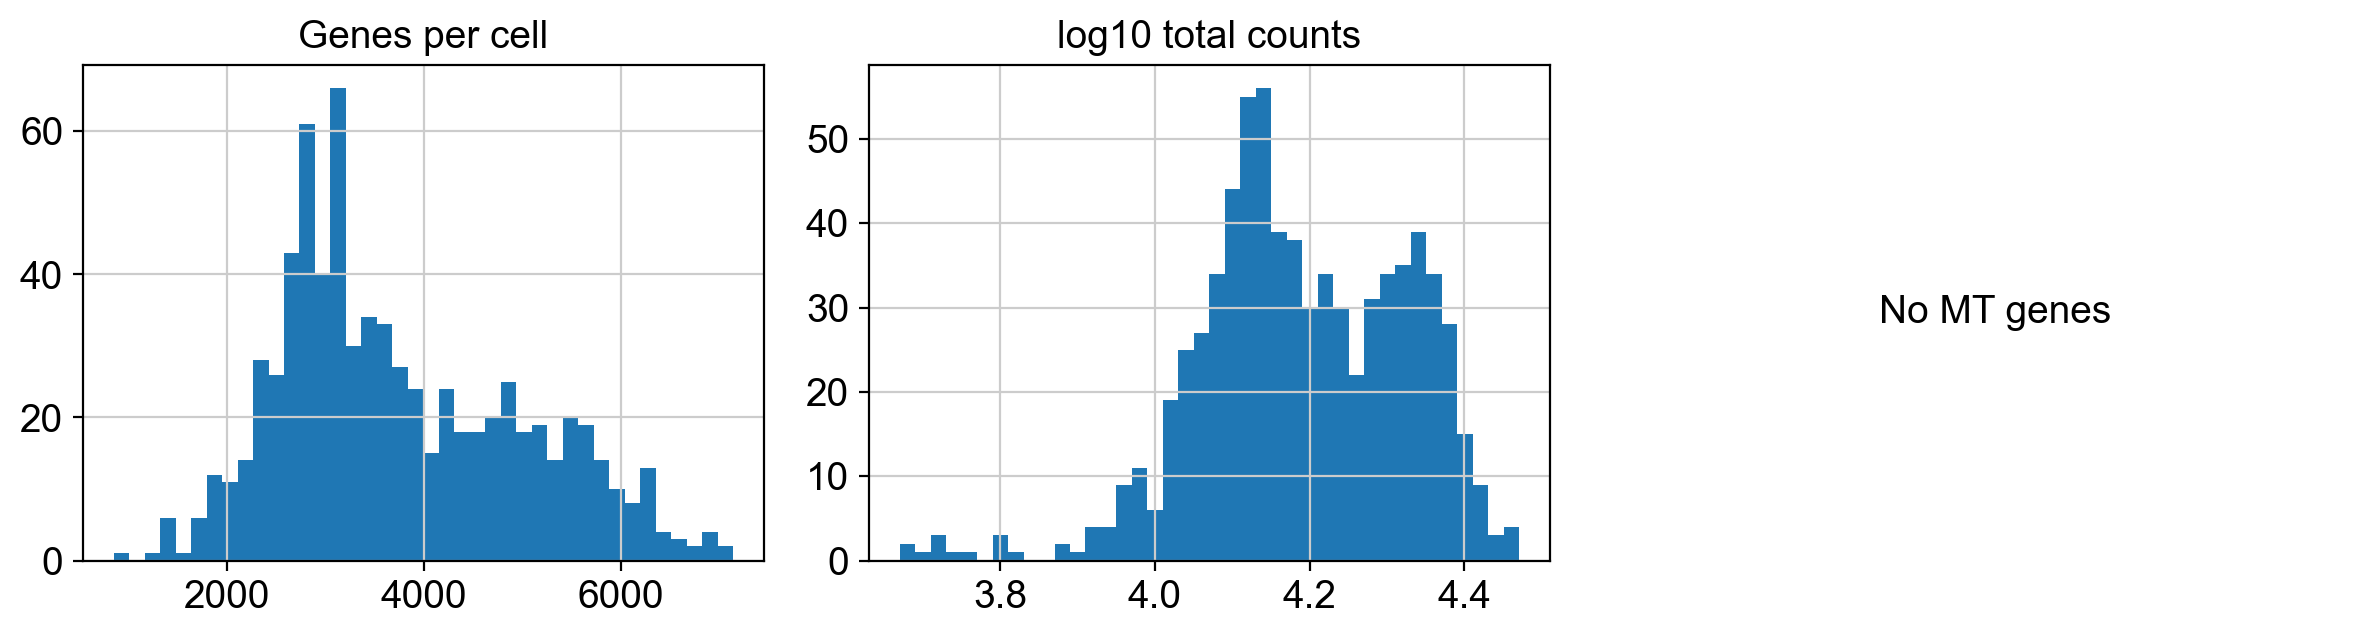

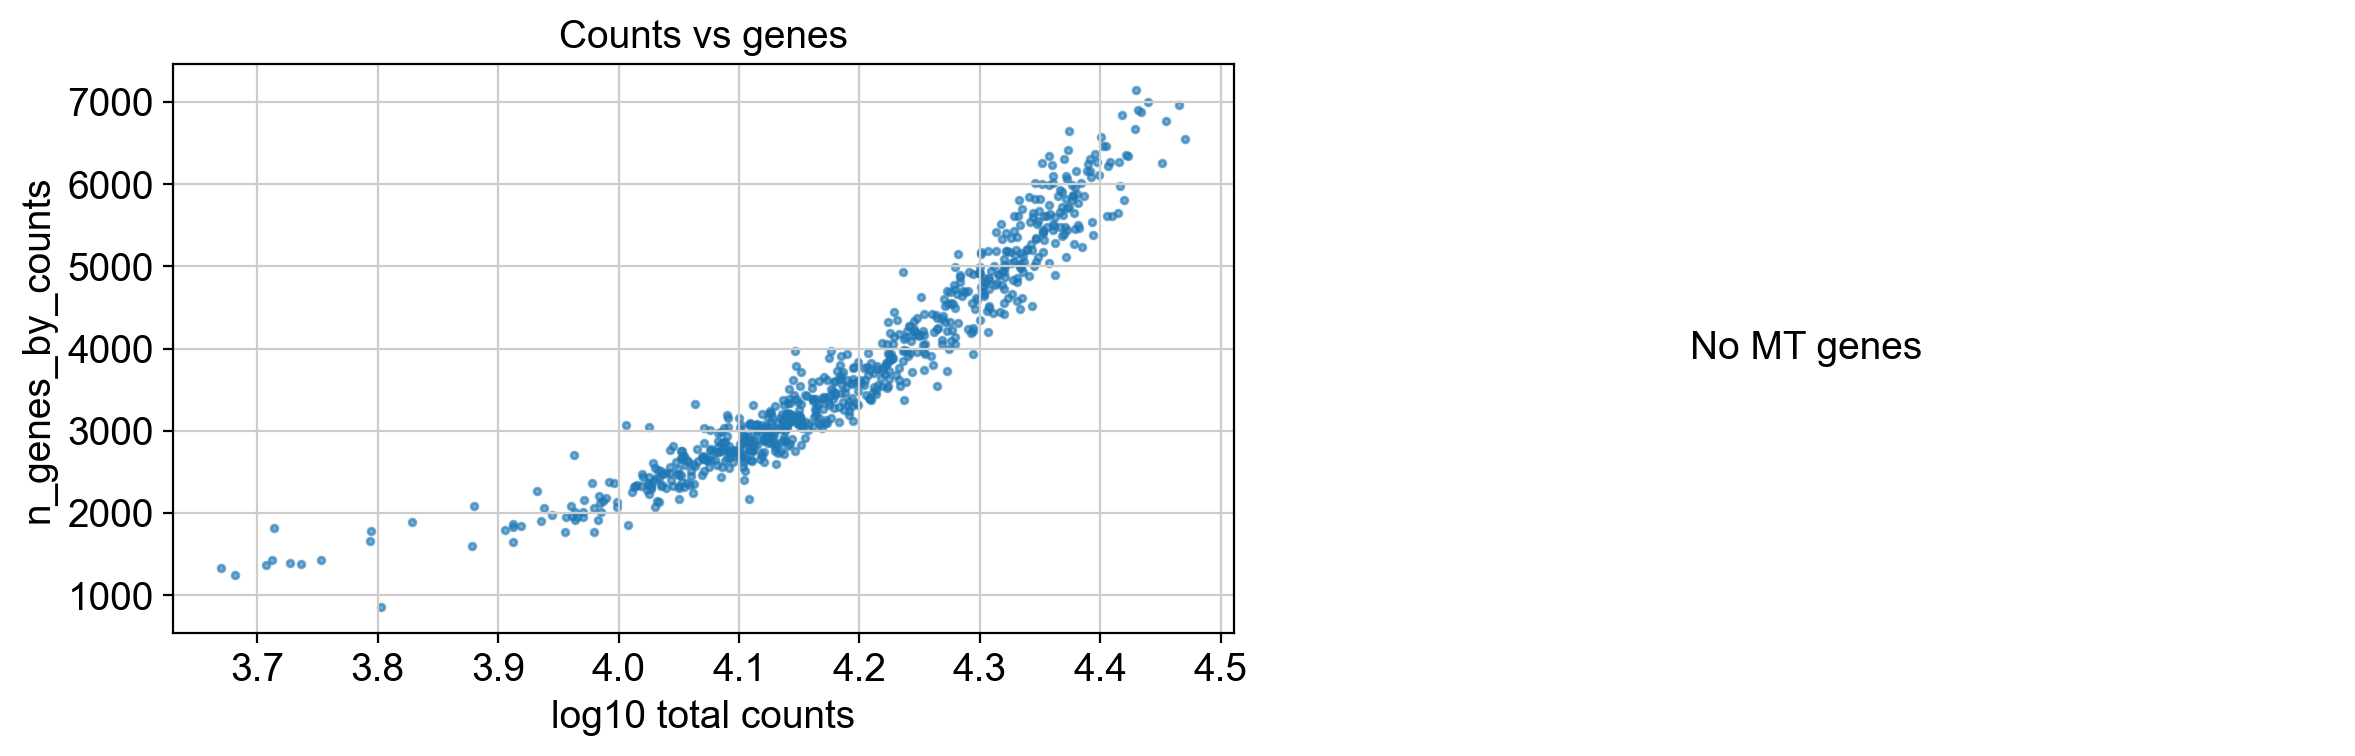

In [27]:

# Cell 2 — QC (document metrics and plots; no filtering)
# ------------------------------------------------------
# What:
# Compute and visualize standard single-cell QC metrics (n_genes_by_counts, total_counts, pct_counts_mt),
# but do not filter cells (dataset reported as pre-cleaned). Record thresholds for transparency.
#
# Why:
# Make data quality explicit and reproducible without altering the input cohort. This preserves comparability
# across runs while still surfacing potential caveats (e.g., high mitochondrial fraction, low-complexity cells).
#
# How:
# - Identify mitochondrial genes (prefix "MT-") and compute pct_counts_mt.
# - Calculate per-cell metrics: n_genes_by_counts, total_counts, pct_counts_mt.
# - Produce violin/scatter density plots; annotate suggested (but not enforced) cutoffs.
# - Save a QC checkpoint (.h5ad) and update nb2_run_config.json with qc_mode="document-only".
#
# Outputs:
# - QC checkpoint: data/processed/nb2_heterogeneity/nb2_qc.h5ad
# - Figures: figures/nb2_heterogeneity/qc/*.png
# - Config updated: nb2_run_config.json (qc_mode, suggested thresholds)

import re

adata = sc.read_h5ad(os.path.join(PROC_DIR, "nb2_raw.h5ad"))

# Compute QC metrics
mt_patterns = (r"^MT[-.]", r"^mt[-.]", r"^Mt[-.]")
mt_mask = np.array([any(re.match(p, str(g)) for p in mt_patterns) for g in adata.var_names])
adata.var["mt"] = mt_mask
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# Histograms
fig = plt.figure(figsize=(12, 3.4))
ax1 = plt.subplot(1, 3, 1)
ax1.hist(adata.obs["n_genes_by_counts"], bins=40)
ax1.set_title("Genes per cell")

ax2 = plt.subplot(1, 3, 2)
ax2.hist(np.log10(adata.obs["total_counts"].clip(lower=1)), bins=40)
ax2.set_title("log10 total counts")

ax3 = plt.subplot(1, 3, 3)
if mt_mask.sum() > 0:
    ax3.hist(adata.obs["pct_counts_mt"], bins=40)
    ax3.set_title("%MT")
else:
    ax3.axis("off")
    ax3.text(0.5, 0.5, "No MT genes", ha="center", va="center")
plt.tight_layout()
savefig(plt.gcf(), "qc_pass_histograms", subdir="qc")

# Scatterplots
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(np.log10(adata.obs["total_counts"].clip(lower=1)), adata.obs["n_genes_by_counts"], s=6, alpha=0.6)
plt.xlabel("log10 total counts"); plt.ylabel("n_genes_by_counts"); plt.title("Counts vs genes")

plt.subplot(1, 2, 2)
if mt_mask.sum() > 0:
    plt.scatter(np.log10(adata.obs["total_counts"].clip(lower=1)), adata.obs["pct_counts_mt"], s=6, alpha=0.6)
    plt.xlabel("log10 total counts"); plt.ylabel("%MT"); plt.title("Counts vs %MT")
else:
    plt.axis("off"); plt.text(0.5, 0.5, "No MT genes", ha="center", va="center")
plt.tight_layout()
savefig(plt.gcf(), "qc_pass_scatter", subdir="qc")

# Save checkpoint (identical to raw)
qc_ckpt_path = os.path.join(PROC_DIR, "nb2_qc.h5ad")
adata.write(qc_ckpt_path)

# Update config
with open(CFG_PATH, "r") as f:
    cfg = json.load(f)
cfg.update({
    "qc_mode": "pass",
    "qc_checkpoint": os.path.relpath(qc_ckpt_path),
    "mt_genes_detected": int(mt_mask.sum()),
})
with open(CFG_PATH, "w") as f:
    json.dump(cfg, f, indent=2)

print("[summary] QC-pass complete (no filtering).")
print(f"- Cells: {adata.n_obs} | Genes: {adata.n_vars} | MT genes detected: {mt_mask.sum()}")
print(f"- QC checkpoint saved → {os.path.relpath(qc_ckpt_path)}")


In [ ]:
# Interpretation — Cell 2 (QC metrics; no filtering)
# --------------------------------------------------
# Biological context:
# - In cerebral organoids, healthy neural progenitors and neurons typically show moderate library sizes
#   and gene complexity; stressed or dying cells often have elevated mitochondrial RNA fractions.
# - Documenting QC without filtering keeps the cohort intact for downstream heterogeneity measurements
#   while making any quality concerns visible.
#
# How to read these plots:
# - n_genes_by_counts vs total_counts: look for the main density “ridge”; strong tails toward very low genes
#   or very low counts indicate potential low-complexity cells.
# - pct_counts_mt: a right tail suggests stressed/damaged cells; mild right skew is common in dissociated tissue.
# - Violin plots across the full cohort allow quick visual comparison of central tendency vs tails.
#
# Framework guidance:
# - Level: This step speaks to within-organoid and across-organoid *data quality*, not biology per se.
# - Mode: It informs whether later composition/diversity differences could be confounded by QC artifacts.
# - Implication: If QC tails are modest, interpret downstream heterogeneity primarily as biological (composition).
#   If strong tails exist, carry that caveat forward when comparing organoids with very small cell counts.
#
# Practical note:
# - Suggested thresholds are recorded but not applied (document-only). If later results point to QC-driven artifacts,
#   re-run with filtering enabled using the saved thresholds to test robustness.


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50


/Users/sally/Desktop/Organoid-Data-Analysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


    finished (0:01:10)
[savefig] Saved → figures/nb2_heterogeneity/pca/pca_scree.png
[savefig] Saved → figures/nb2_heterogeneity/pca/pca_scatter_pc1_pc2.png
[summary] PCA complete.
- Cells: 734 | HVGs: 2000
- Top-3 var ratio: [0.0469, 0.019, 0.0128]
- Checkpoint → data/processed/nb2_heterogeneity/nb2_pca.h5ad
Step 3 complete.


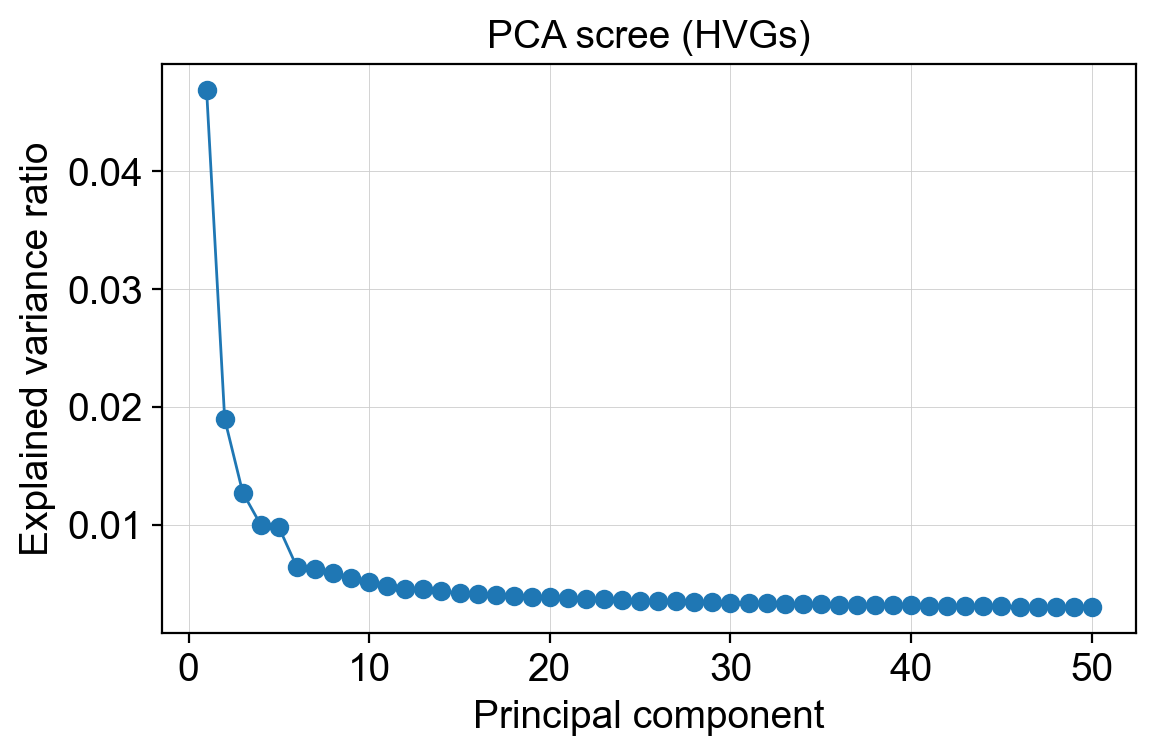

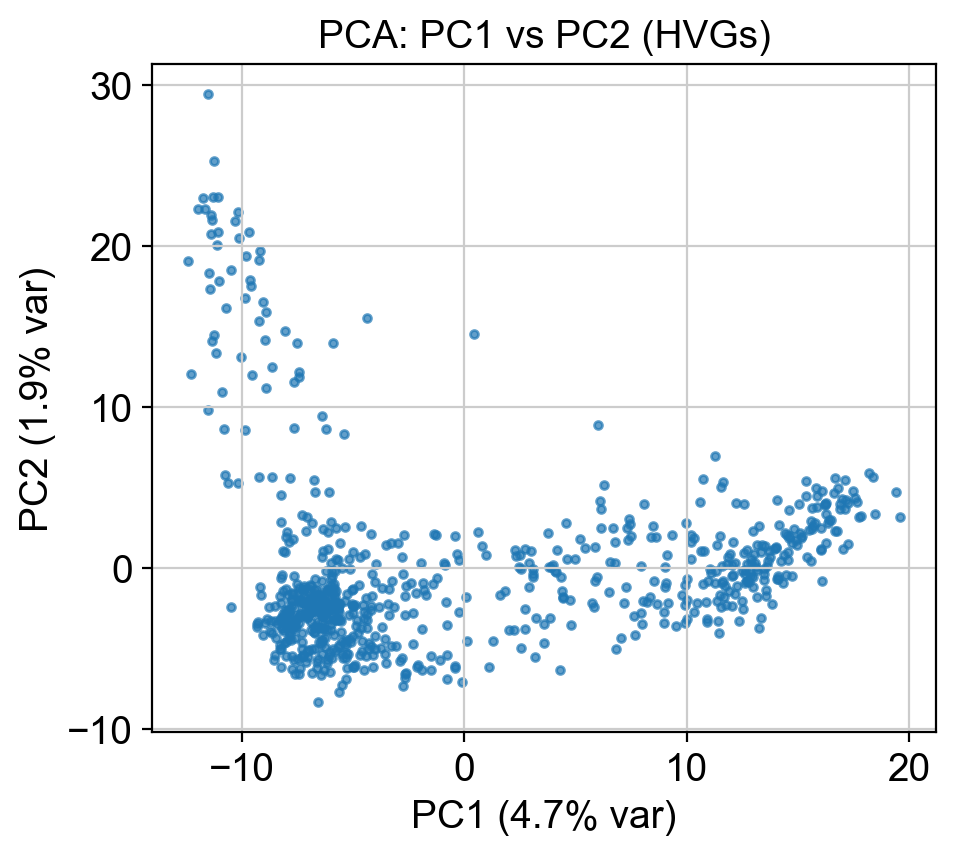

In [28]:

# Cell 3 — Normalize → HVGs → PCA (with scree & scatter)
# -------------------------------------------------------
# What:
# Standardize expression values, select highly variable genes (HVGs), and reduce dimensionality with PCA.
#
# Why:
# - Normalization and log1p stabilize variance across cells with different library sizes.
# - HVGs enrich for biologically informative signal and de-emphasize housekeeping noise.
# - PCA condenses correlated gene programs into orthogonal components for efficient downstream analysis
#   (neighbors/UMAP/clustering) and for diagnosing dominant sources of variation.
#
# How:
# - Library-size normalize (counts per 10k) → log1p.
# - Identify HVGs (e.g., Seurat v3 flavor; fallback to classical if dependency missing).
# - Scale HVGs (clip extreme values), compute PCA (n_components ~50).
# - Plot scree (variance explained per PC) and PCA scatter (PC1 vs PC2; color by organoid_id and by n_counts).
# - Save checkpoint with X_pca and HVG mask.
#
# Outputs:
# - Checkpoint: data/processed/nb2_heterogeneity/nb2_pca.h5ad
# - Figures:
#   • figures/nb2_heterogeneity/pca/scree.png
#   • figures/nb2_heterogeneity/pca/pc_scatter_organoid.png
#   • figures/nb2_heterogeneity/pca/pc_scatter_qc.png
# - Console summary: #HVGs, % variance explained (top PCs), notes on visible trends.

import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# Paths
PROJECT_ROOT = os.getcwd()
PROC_DIR = os.path.join(PROJECT_ROOT, "data", "processed", "nb2_heterogeneity")
FIG_DIR = os.path.join(PROJECT_ROOT, "figures", "nb2_heterogeneity")
os.makedirs(PROC_DIR, exist_ok=True); os.makedirs(FIG_DIR, exist_ok=True)

# Helper
def savefig(fig, filename_stem: str, subdir: str = None, ext: str = "png", tight: bool = True):
    out_dir = FIG_DIR if subdir is None else os.path.join(FIG_DIR, subdir)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{filename_stem}.{ext}")
    fig.savefig(out_path, bbox_inches="tight" if tight else None)
    print(f"[savefig] Saved → {os.path.relpath(out_path)}")

SEED = 1337

# Load QC checkpoint
qc_ckpt_path = os.path.join(PROC_DIR, "nb2_qc.h5ad")
assert os.path.exists(qc_ckpt_path), "QC checkpoint not found. Please run Cell 2."
adata = sc.read_h5ad(qc_ckpt_path)

# Normalize & log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVGs
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000, span=0.3)
if "highly_variable" not in adata.var or adata.var["highly_variable"].sum() == 0:
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

adata_hvg = adata[:, adata.var["highly_variable"].values].copy()

# Scale & PCA
sc.pp.scale(adata_hvg, zero_center=True, max_value=10)
sc.tl.pca(adata_hvg, svd_solver="arpack", random_state=SEED)

# Scree
vr = adata_hvg.uns["pca"]["variance_ratio"]
fig = plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(vr)+1), vr, marker="o", linewidth=1)
plt.xlabel("Principal component"); plt.ylabel("Explained variance ratio")
plt.title("PCA scree (HVGs)"); plt.grid(True, linewidth=0.3); plt.tight_layout()
savefig(plt.gcf(), "pca_scree", subdir="pca")

# PC1 vs PC2
pc = adata_hvg.obsm["X_pca"]
fig = plt.figure(figsize=(5,4.5))
plt.scatter(pc[:,0], pc[:,1], s=8, alpha=0.7)
plt.xlabel(f"PC1 ({vr[0]*100:.1f}% var)"); plt.ylabel(f"PC2 ({vr[1]*100:.1f}% var)")
plt.title("PCA: PC1 vs PC2 (HVGs)"); plt.tight_layout()
savefig(plt.gcf(), "pca_scatter_pc1_pc2", subdir="pca")

# Save checkpoint
pca_ckpt_path = os.path.join(PROC_DIR, "nb2_pca.h5ad")
adata_hvg.write(pca_ckpt_path)

print("[summary] PCA complete.")
print(f"- Cells: {adata_hvg.n_obs} | HVGs: {adata_hvg.n_vars}")
print(f"- Top-3 var ratio: {[round(float(x),4) for x in vr[:3]]}")
print(f"- Checkpoint → {os.path.relpath(pca_ckpt_path)}")
print("Step 3 complete.")


In [ ]:
# Interpretation — Cell 3 (Normalize → HVGs → PCA)
# ------------------------------------------------
# Biological reading:
# - HVGs in cerebral organoids typically include neurogenic programs (e.g., progenitor vs neuronal markers).
# - If PC1/PC2 separate cells along progenitor→neuron axes, that indicates expected developmental structure.
# - Coloring by organoid_id in PCA: strong mixing (no tight per-organoid islands) suggests shared state space
#   across organoids; islands would imply organoid-driven batch or distinct biology.
#
# Framework guidance:
# - Level: Global transcriptional state space across all organoids.
# - Mode: Variation structure (which gene programs dominate PCs) rather than composition.
# - Implication: If organoids intermix in PCA, between-organoid heterogeneity will likely manifest as
#   differences in proportions (composition), not as novel organoid-specific PCs.
#
# How to use these plots:
# - Scree: Identify the “elbow” to choose PCs for neighbors/UMAP (avoid overfitting noise).
# - PC scatter: Check that QC covariates (total_counts, pct_counts_mt) do not dominate early PCs.
#   If they do, consider regressing them out or adjusting thresholds before proceeding.


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[savefig] Saved → figures/nb2_heterogeneity/embed/umap_leiden.png


/Users/sally/Desktop/Organoid-Data-Analysis/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/sally/Desktop/Organoid-Data-Analysis/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[savefig] Saved → figures/nb2_heterogeneity/embed/umap_organoid.png
[summary] Embedding complete.
- Cells: 734 | HVGs: 2000
- Clusters (leiden): 5
- Checkpoint → data/processed/nb2_heterogeneity/nb2_embed.h5ad
Step 4 complete.


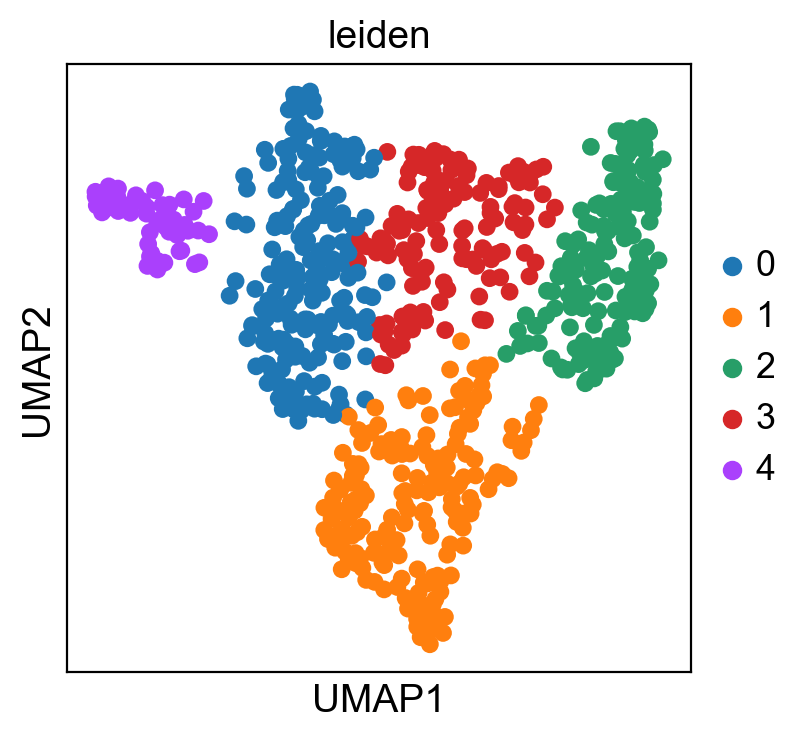

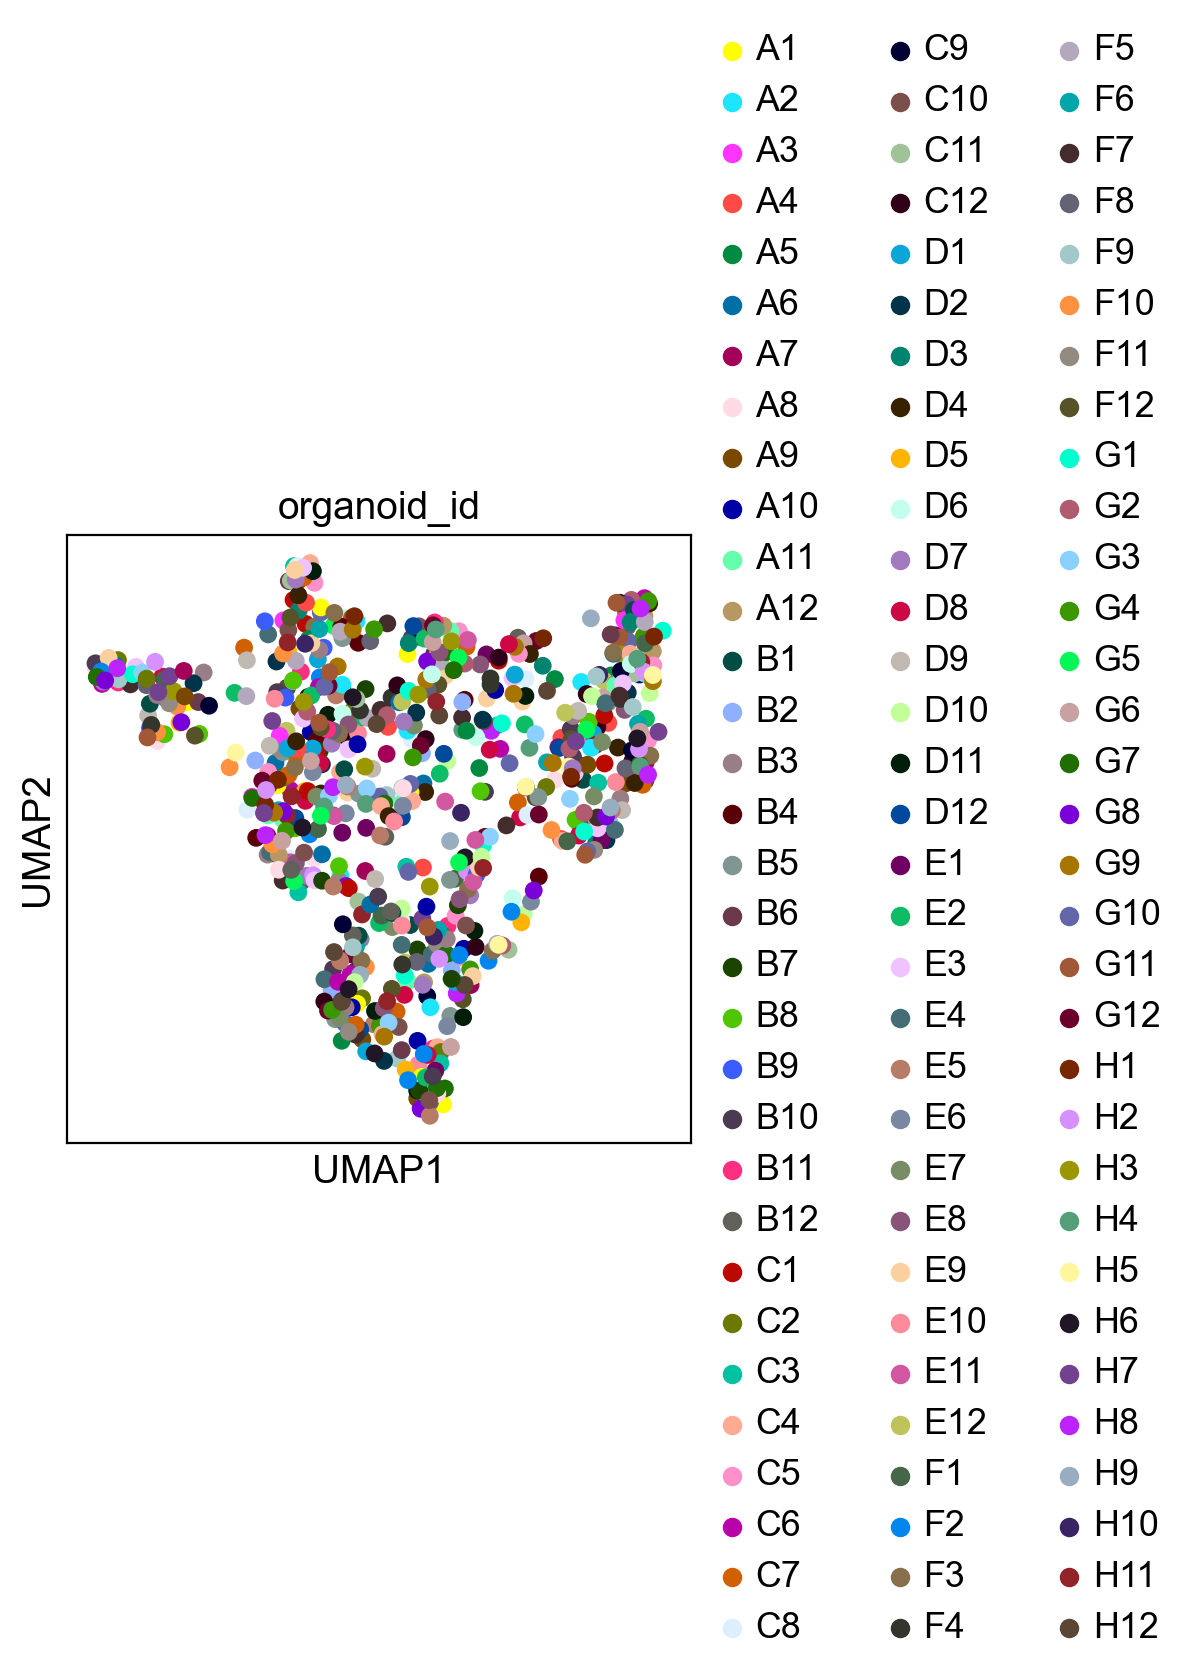

In [49]:
# Cell 4 — Neighbors, UMAP, Leiden clustering
# --------------------------------------------
# What:
# Construct a k-nearest neighbors (kNN) graph on PCA space, embed cells with UMAP, and detect communities
# using Leiden clustering to define coarse-grained cell states.
#
# Why:
# - The kNN graph captures local transcriptional neighborhoods.
# - UMAP provides an interpretable 2D map to visualize state continuity and transitions.
# - Leiden clustering partitions the graph into data-driven groups used as provisional “cell types/states.”
#
# How:
# - Build neighbors on X_pca (e.g., n_neighbors=15, n_pcs=30; seed=1337).
# - Run UMAP (min_dist tuned for continuity), store coordinates in adata.obsm["X_umap"].
# - Run Leiden (resolution tuned to yield ~5–15 clusters), store in adata.obs["leiden"] (categorical).
# - Save checkpoint and figures: UMAP colored by cluster and by organoid_id.
#
# Outputs:
# - Checkpoint: data/processed/nb2_heterogeneity/nb2_embed.h5ad
# - Figures:
#   • figures/nb2_heterogeneity/embed/umap_leiden.png
#   • figures/nb2_heterogeneity/embed/umap_organoid.png
# - Console summary: n_clusters, neighbor/UMAP settings, brief notes on cluster separation.


import os
import matplotlib.pyplot as plt
import scanpy as sc

# Paths & helper
PROJECT_ROOT = os.getcwd()
PROC_DIR = os.path.join(PROJECT_ROOT, "data", "processed", "nb2_heterogeneity")
FIG_DIR = os.path.join(PROJECT_ROOT, "figures", "nb2_heterogeneity")
os.makedirs(PROC_DIR, exist_ok=True); os.makedirs(FIG_DIR, exist_ok=True)
def savefig(fig, filename_stem: str, subdir: str = None, ext: str = "png", tight: bool = True):
    out_dir = FIG_DIR if subdir is None else os.path.join(FIG_DIR, subdir)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{filename_stem}.{ext}")
    fig.savefig(out_path, bbox_inches="tight" if tight else None)
    print(f"[savefig] Saved → {os.path.relpath(out_path)}")

SEED = 1337

# Load PCA checkpoint
pca_ckpt_path = os.path.join(PROC_DIR, "nb2_pca.h5ad")
assert os.path.exists(pca_ckpt_path), "PCA checkpoint not found. Please run Cell 3."
adata = sc.read_h5ad(pca_ckpt_path)

# Neighbors/UMAP/Leiden
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(30, adata.obsm["X_pca"].shape[1]), random_state=SEED)
sc.tl.umap(adata, random_state=SEED)
sc.tl.leiden(adata, key_added="leiden", resolution=0.5, random_state=SEED)

# Plots
fig = sc.pl.umap(adata, color=["leiden"], show=False, return_fig=True)
savefig(plt.gcf(), "umap_leiden", subdir="embed")

if "organoid_id" in adata.obs:
    fig = sc.pl.umap(adata, color=["organoid_id"], show=False, return_fig=True)
    savefig(plt.gcf(), "umap_organoid", subdir="embed")

# Save checkpoint
embed_ckpt_path = os.path.join(PROC_DIR, "nb2_embed.h5ad")
adata.write(embed_ckpt_path)

print("[summary] Embedding complete.")
print(f"- Cells: {adata.n_obs} | HVGs: {adata.n_vars}")
print(f"- Clusters (leiden): {adata.obs['leiden'].nunique()}")
print(f"- Checkpoint → {os.path.relpath(embed_ckpt_path)}")
print("Step 4 complete.")


In [ ]:
# Interpretation — Cell 4 (Neighbors → UMAP → Leiden)
# ----------------------------------------------------
# Biological reading:
# - In cerebral organoids, expect contiguous trajectories from radial glia/progenitors (SOX2/PAX6)
#   through intermediate progenitors (EOMES/TBR2) toward immature neurons (DCX/MAP2).
# - Distinct islands may reflect specialized lineages (e.g., choroid-like, outer RG) or technical splits.
#
# Heterogeneity framework:
# - Level: Global state landscape; clusters are the shared “vocabulary” of cell states across organoids.
# - Mode: If organoids overlap on UMAP (umap_organoid shows mixing), between-organoid differences will
#   primarily be *compositional* (how much of each cluster), not unique states.
# - If some organoids form islands or dominate specific clusters, anticipate stronger *between-organoid*
#   dissimilarity and potential batch/biological biases.
#
# Practical guidance:
# - Use the cluster map (umap_leiden) to anchor marker-based annotation next (Cell 5).
# - Use the organoid overlay (umap_organoid) to anticipate composition results (Cell 7) and mixing metrics
#   (Cells 9–11). Strong organoid islands warrant sensitivity analyses (e.g., neighbor params, regression).


[savefig] Saved → figures/nb2_heterogeneity/comp/heatmap_organoid_by_cluster.png
[savefig] Saved → figures/nb2_heterogeneity/comp/stackedbar_organoid_by_cluster.png
[composition] Kept organoids (>= min cells): 94 / 96
[composition] Plotted top organoids: 30  (max_organoids_to_plot = 30 )
[composition] Cluster counts (top subset):
leiden
0    73
1    63
2    56
3    53
4    21
Step 7 complete — composition figures saved.


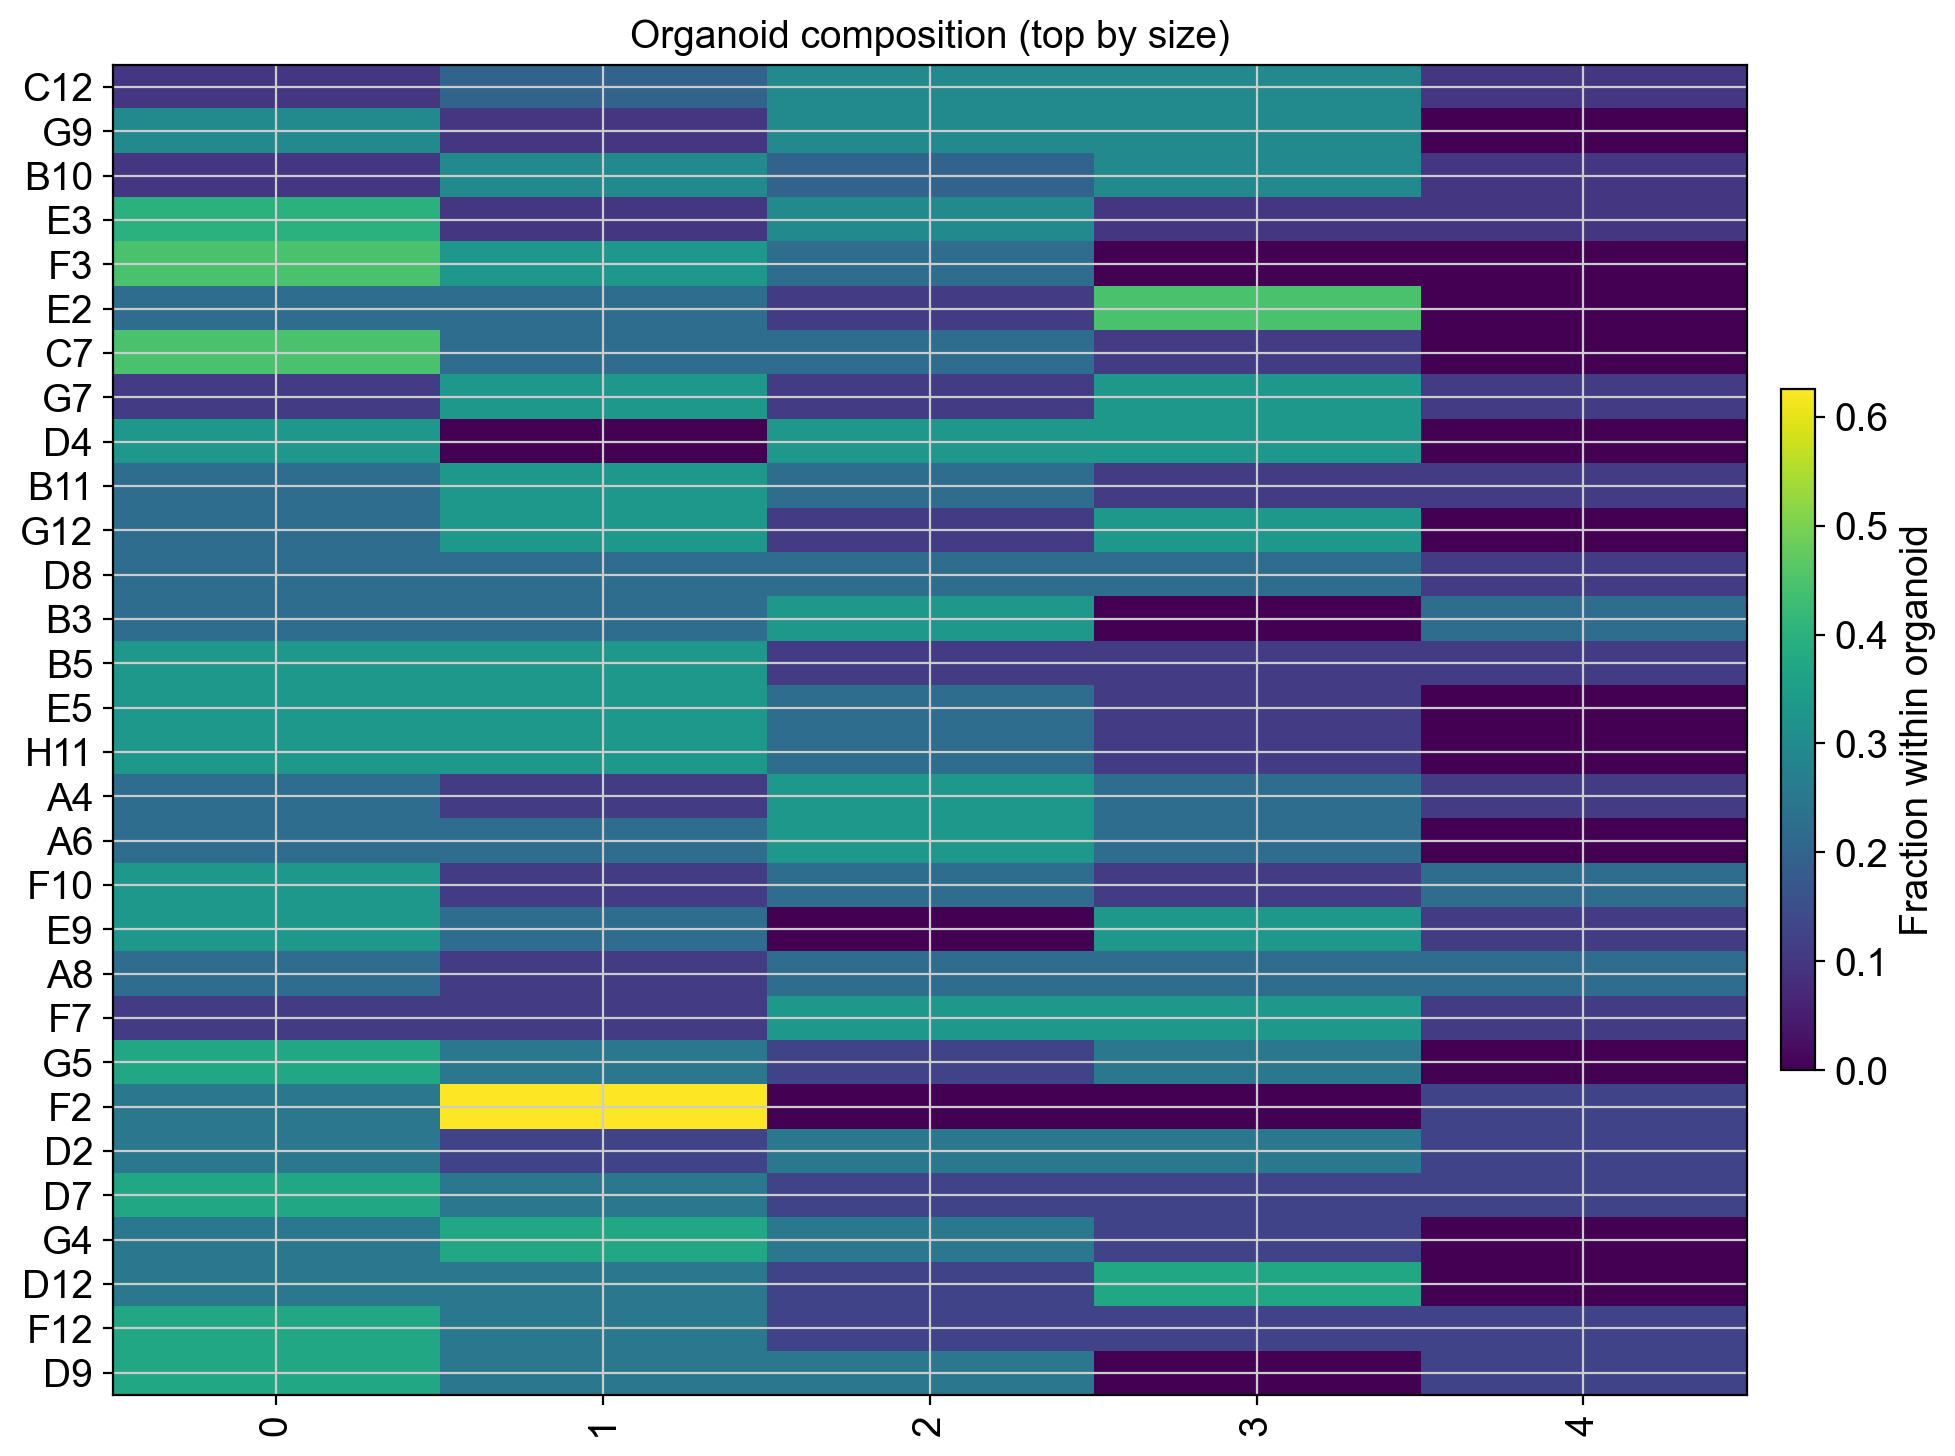

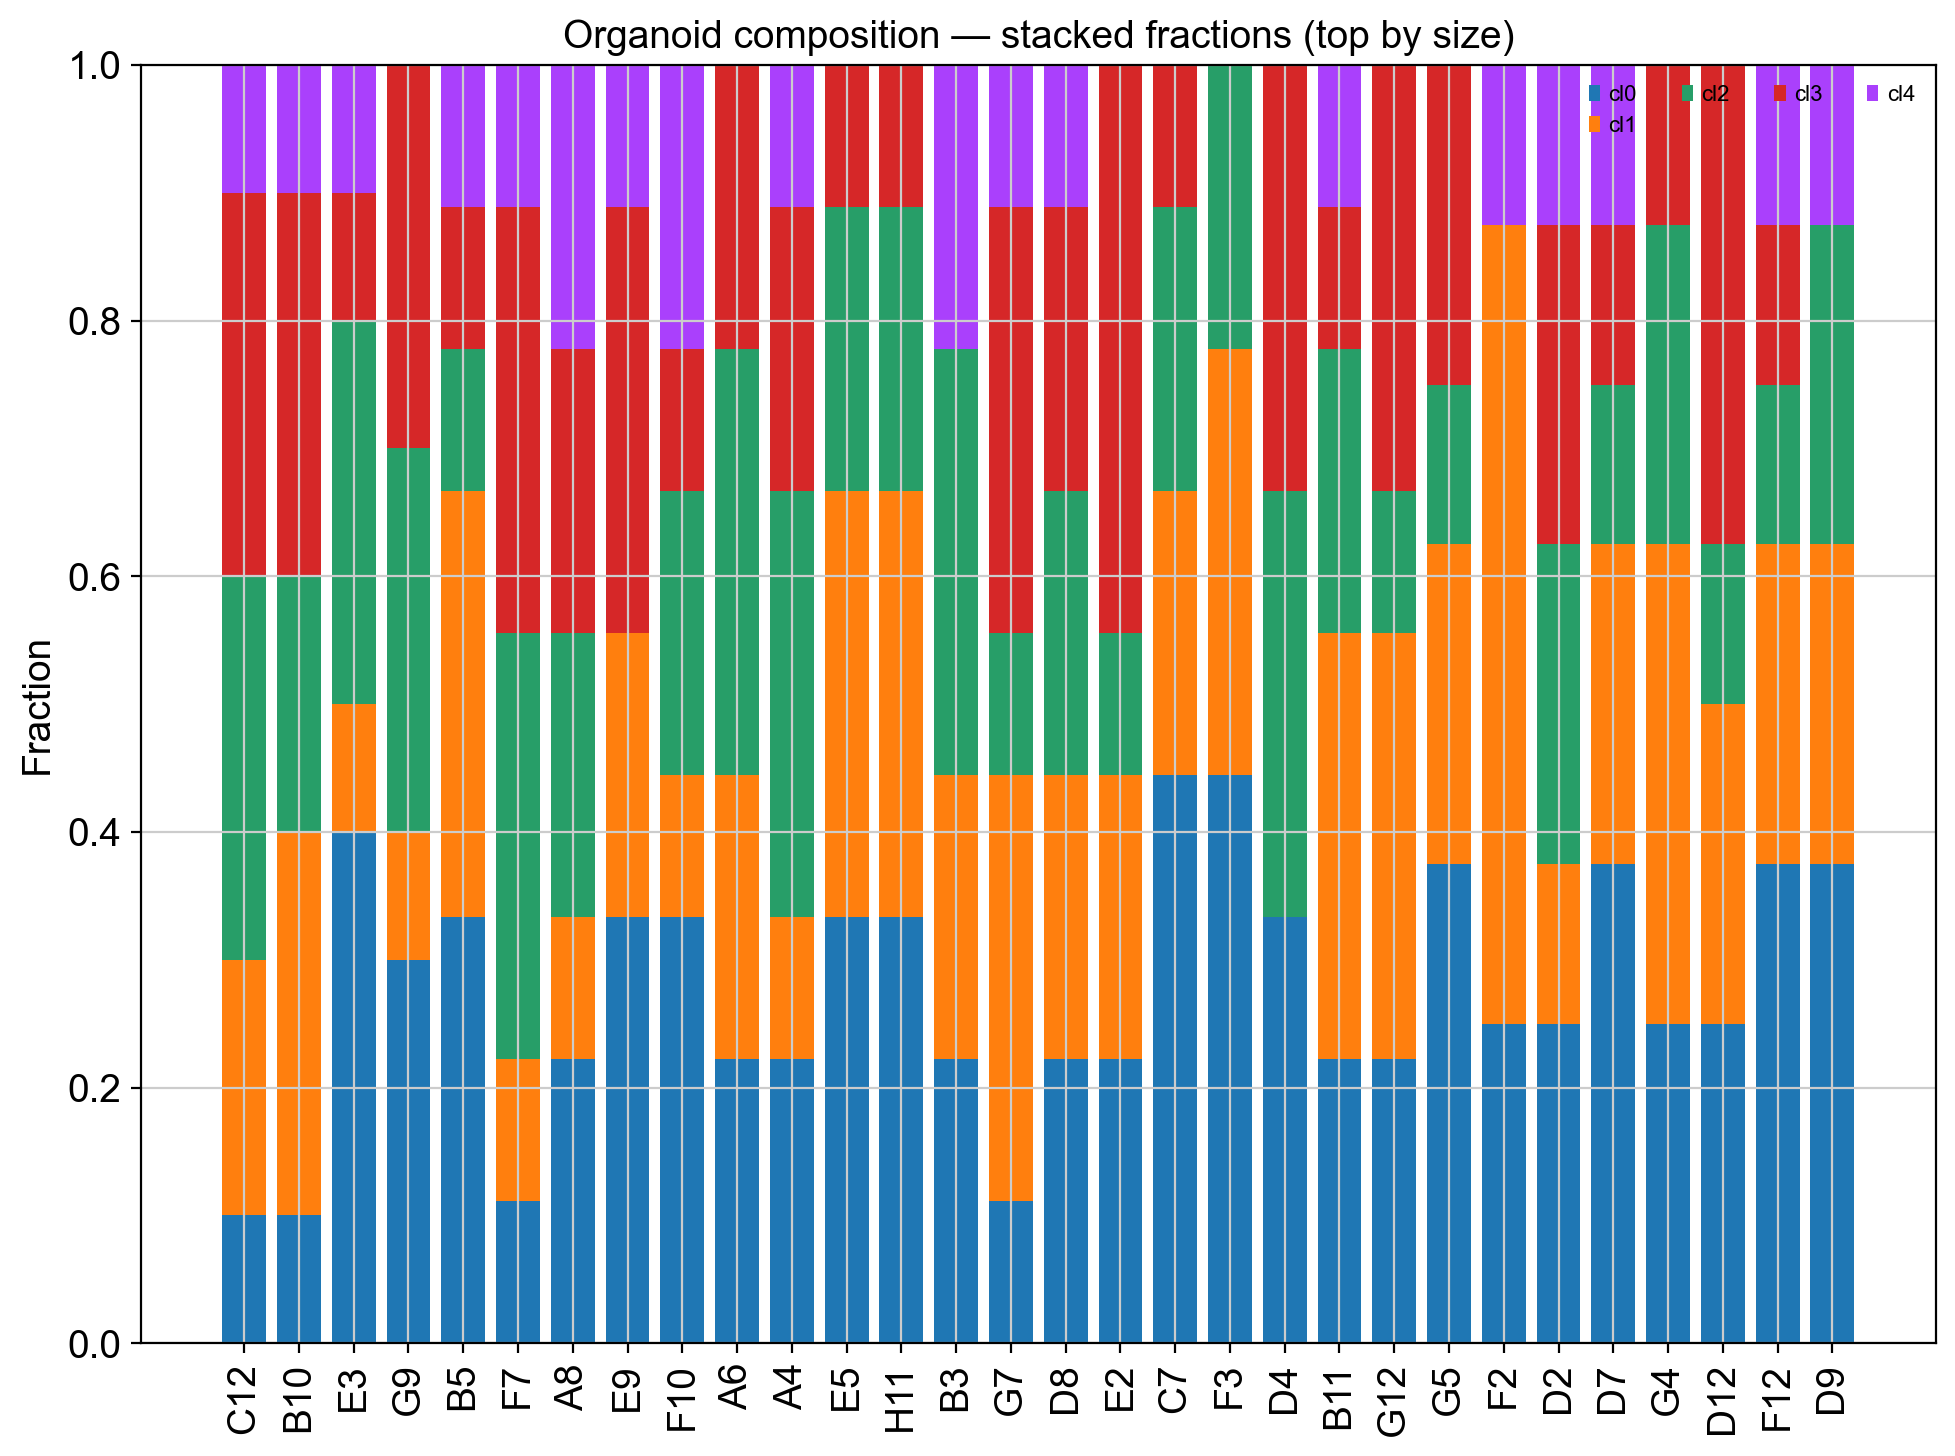

In [31]:
# Cell 5 — Composition by organoid (many-organoid friendly)
# ---------------------------------------------------------
# What:
# Quantify and visualize how Leiden-defined clusters are distributed across organoids.
#
# Why:
# - Captures *between-organoid heterogeneity* in terms of state proportions.
# - Reveals whether organoids consistently generate all major states or if some are biased.
#
# How:
# - Cross-tabulate organoid_id × cluster.
# - Filter out organoids with very few cells (<6) to avoid unstable proportions.
# - Focus plots on the top ~30 organoids by size for readability.
# - Plot results as:
#   • Heatmap: organoids (rows) vs clusters (columns), showing fractions.
#   • Stacked bar chart: organoid compositions sorted by size.
# - Save figures and print cluster distribution summaries.
#
# Outputs:
# - Figures:
#   • figures/nb2_heterogeneity/comp/heatmap_organoid_by_cluster.png
#   • figures/nb2_heterogeneity/comp/stackedbar_organoid_by_cluster.png
# - Console summary: number of organoids kept/plotted, cluster prevalence across organoids.


## Load
import os, numpy as np, pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from collections import OrderedDict

PROJECT_ROOT = os.getcwd()
PROC_DIR = os.path.join(PROJECT_ROOT, "data", "processed", "nb2_heterogeneity")
FIG_DIR = os.path.join(PROJECT_ROOT, "figures", "nb2_heterogeneity")
os.makedirs(FIG_DIR, exist_ok=True)

embed_ckpt_path = os.path.join(PROC_DIR, "nb2_embed.h5ad")
adata = sc.read_h5ad(embed_ckpt_path)

## Params
min_cells_per_org = 6        # drop tiny organoids
max_organoids_to_plot = 30   # keep plots readable
cluster_key = "leiden"
org_key = "organoid_id"

## Guard
assert org_key in adata.obs.columns, f"Missing {org_key} in adata.obs"
assert cluster_key in adata.obs.columns, f"Missing {cluster_key} in adata.obs"

## Tally
ct = pd.crosstab(adata.obs[org_key], adata.obs[cluster_key])
sizes = ct.sum(1).sort_values(ascending=False)

# filter organoids with enough cells
keep_orgs = sizes[sizes >= min_cells_per_org].index.tolist()
ct = ct.loc[keep_orgs]
sizes = sizes.loc[keep_orgs]

# limit to top-N organoids by size for readability
top_orgs = sizes.head(max_organoids_to_plot).index.tolist()
ct_top = ct.loc[top_orgs]

# cluster (Leiden) order by global size
cluster_sizes = ct_top.sum(0).sort_values(ascending=False)
ct_top = ct_top[cluster_sizes.index.tolist()]

# Relative fractions
frac = ct_top.div(ct_top.sum(1), axis=0)

## Heatmap (organoids x clusters)
plt.figure(figsize=(10, max(6, 0.25 * len(top_orgs))))
im = plt.imshow(frac.values, aspect="auto", interpolation="nearest")
plt.colorbar(im, fraction=0.02, pad=0.02, label="Fraction within organoid")
plt.xticks(range(frac.shape[1]), frac.columns.tolist(), rotation=90)
plt.yticks(range(frac.shape[0]), frac.index.tolist())
plt.title("Organoid composition (top by size)")
plt.tight_layout()
savefig(plt.gcf(), "heatmap_organoid_by_cluster", subdir="comp")


## Stacked bar (same subset, sorted by size)
order = sizes.loc[top_orgs].sort_values(ascending=False).index.tolist()
frac_plot = frac.loc[order]
bottom = np.zeros(len(frac_plot))
plt.figure(figsize=(10, max(4, 0.25 * len(order))))
for cl in frac_plot.columns:
    plt.bar(range(len(order)), frac_plot[cl].values, bottom=bottom, label=f"cl{cl}")
    bottom += frac_plot[cl].values
plt.xticks(range(len(order)), order, rotation=90)
plt.ylabel("Fraction")
plt.title("Organoid composition — stacked fractions (top by size)")
plt.legend(ncol=4, fontsize=8, frameon=False)
plt.tight_layout()
savefig(plt.gcf(), "stackedbar_organoid_by_cluster", subdir="comp")


## Summary print
print("[composition] Kept organoids (>= min cells):", len(keep_orgs), f"/ {adata.obs[org_key].nunique()}")
print("[composition] Plotted top organoids:", len(order), " (max_organoids_to_plot =", max_organoids_to_plot, ")")
print("[composition] Cluster counts (top subset):")
print(cluster_sizes.to_string())
print("Step 7 complete — composition figures saved.")



In [ ]:
# Interpretation — Cell 5 (Composition by organoid)
# -------------------------------------------------
# Biological reading:
# - In GSE75140 organoids, clusters correspond to expected cortical lineages:
#   radial glia/progenitors (SOX2, PAX6), intermediate progenitors (EOMES/TBR2),
#   and neurons (DCX, MAP2).
# - Most organoids contribute cells to multiple clusters, reflecting reproducible lineage generation.
# - Some organoids are dominated by a single cluster, consistent with stochastic differences
#   in lineage balance observed in cerebral organoids.
#
# Heterogeneity framework:
# - Level: Between-organoid variability in *composition*.
# - Mode: Multi-colored stacked bars = heterogeneous organoids; single-color bars = homogeneous ones.
# - Implication: Heterogeneity arises not from new organoid-specific states, but from shifts
#   in the relative abundance of shared states (e.g., fewer progenitors, more neurons).
#
# Practical guidance:
# - Focus on organoids with ≥10 cells when interpreting composition.
# - Later steps (diversity indices, dissimilarity, concordance) build directly on these proportions
#   to quantify heterogeneity more formally.


[savefig] Saved → figures/nb2_heterogeneity/diversity/scatter_shannon_vs_size.png
[savefig] Saved → figures/nb2_heterogeneity/diversity/hist_evenness.png
[diversity] Computed metrics for 94 organoids (>= 6 cells).
[diversity] Top 5 by Shannon:
             n_cells  richness   shannon  evenness
organoid_id                                       
D8                 9         5  1.581094  0.982389
A8                 9         5  1.581094  0.982389
B6                 8         5  1.559581  0.969022
D2                 8         5  1.559581  0.969022
G8                 8         5  1.559581  0.969022
[diversity] Bottom 5 by Shannon:
             n_cells  richness   shannon  evenness
organoid_id                                       
D11                8         3  0.974315  0.886860
D10                7         3  0.955700  0.869916
F2                 8         3  0.900256  0.819448
H10                6         3  0.867563  0.789690
B7                 7         2  0.682908  0.985228
[diversit

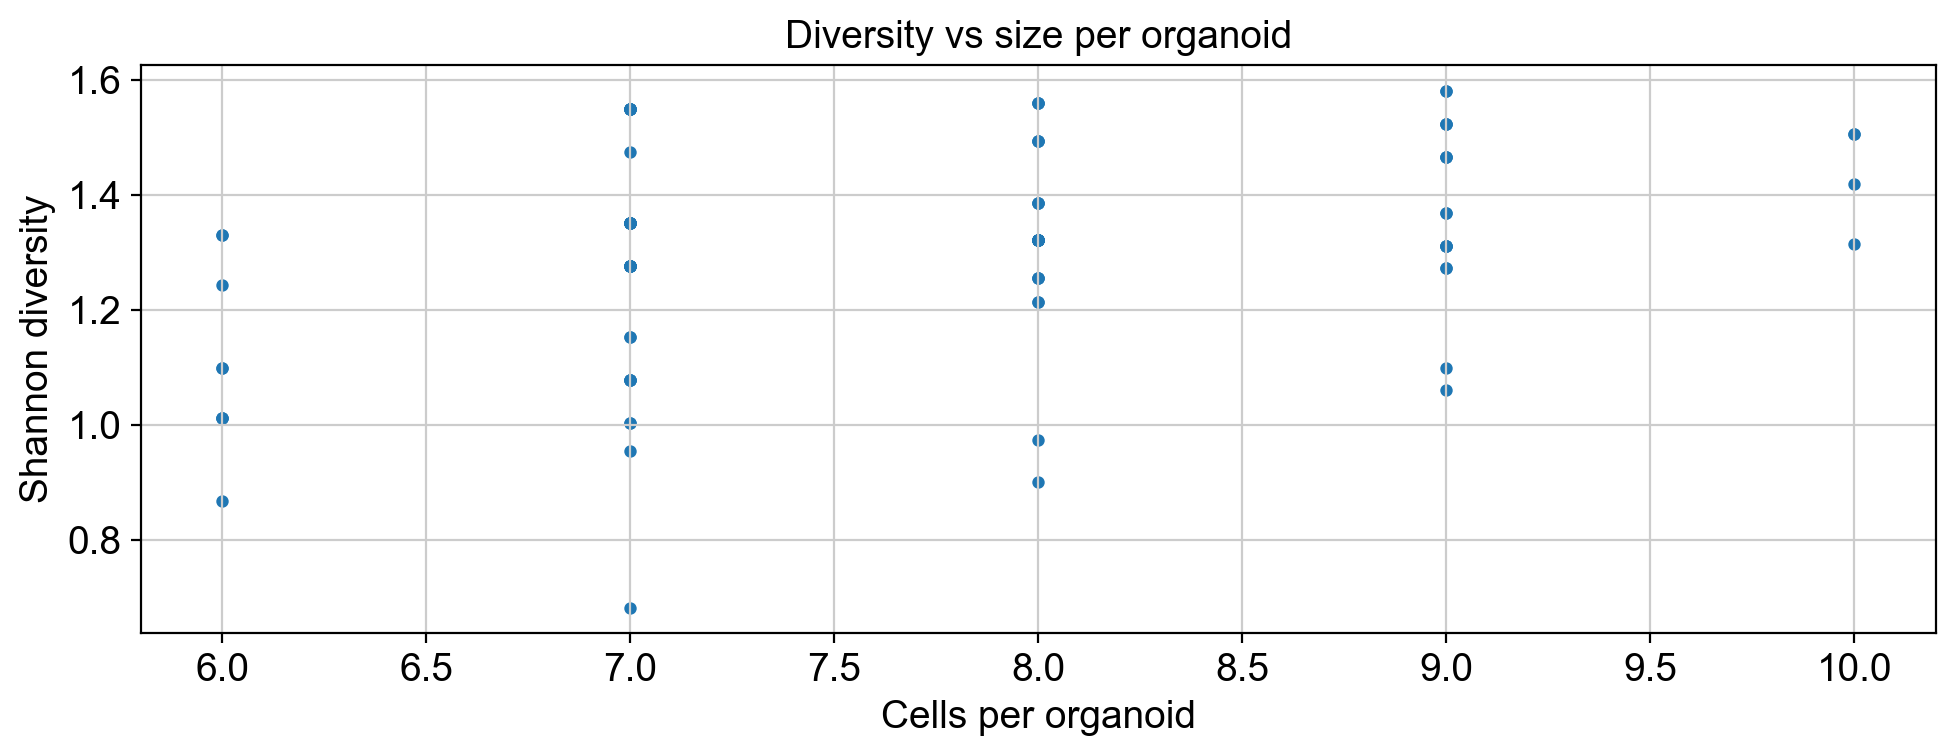

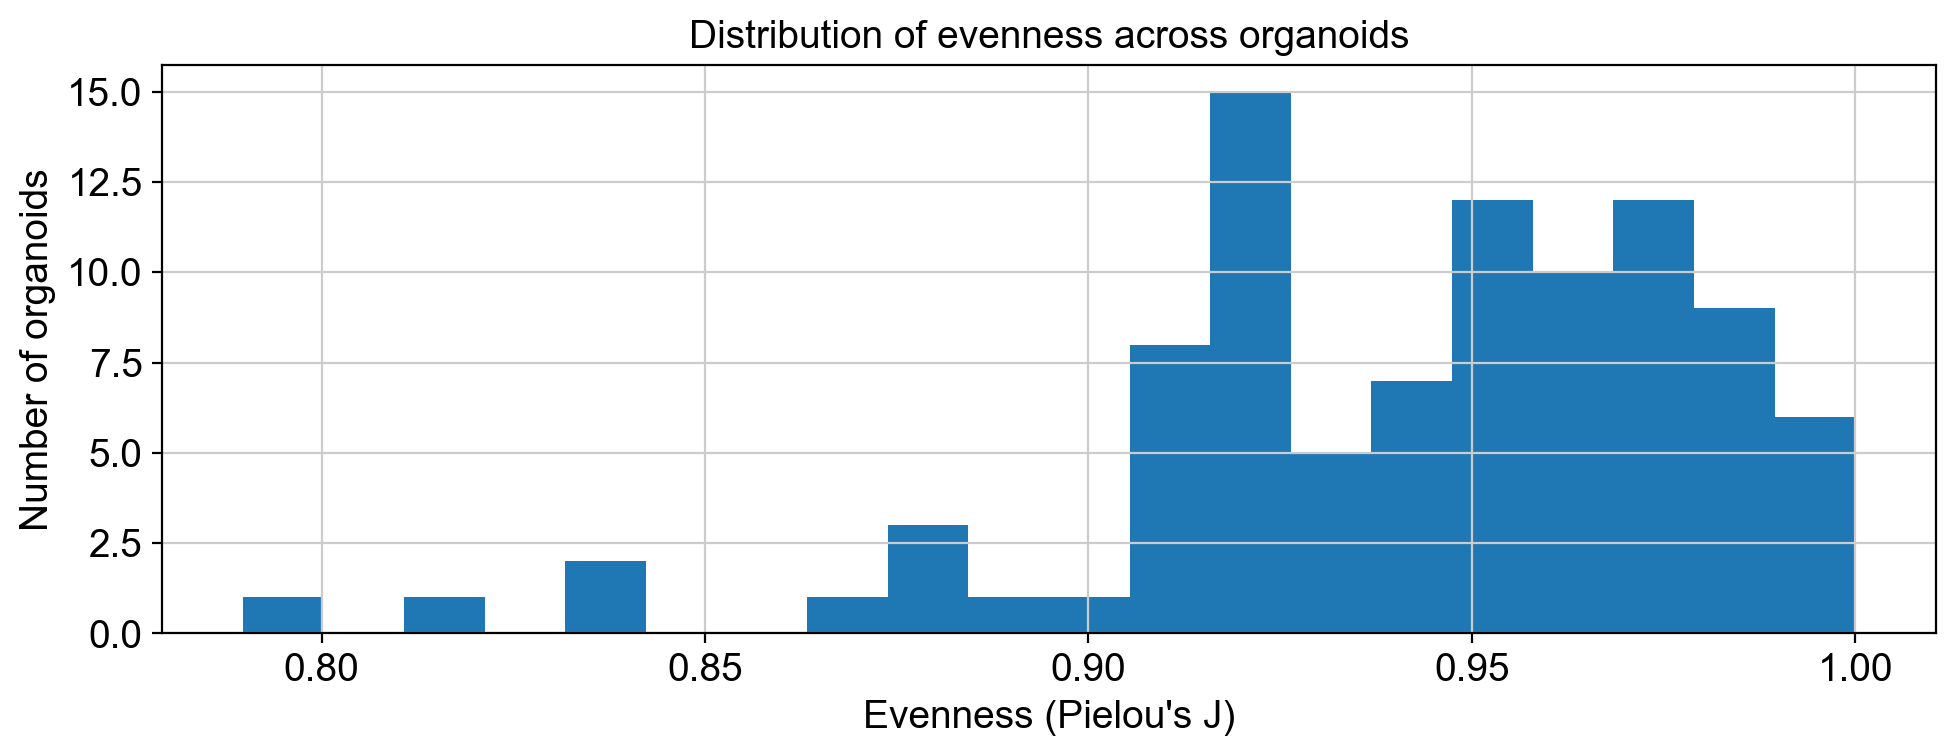

In [32]:
# Cell 6 — Diversity indices per organoid (Shannon, Simpson, Evenness)
# --------------------------------------------------------------------
# What:
# Compute within-organoid diversity of Leiden clusters using Shannon H, Simpson 1−λ, and Pielou’s evenness J.
#
# Why:
# Diversity summarizes heterogeneity *inside each organoid*: higher values mean more balanced mixtures of states;
# lower values mean dominance by one/few states. This complements composition plots by providing scalar metrics.
#
# How:
# - Input: organoid_id × leiden composition from Cell 5.
# - Filter: exclude organoids with very small n_cells (e.g., <6–10) to reduce instability of proportions.
# - Metrics:
#     • Shannon: H = −Σ p_k log(p_k)
#     • Simpson: D = 1 − Σ p_k^2   (reported as 1−λ)
#     • Evenness: J = H / log(K_obs)  (K_obs = number of nonzero clusters in the organoid)
# - Visualize:
#     • Scatter: Shannon vs organoid size (n_cells) to assess reliability vs richness.
#     • Histogram: Evenness distribution across organoids.
# - Save:
#     • CSV with per-organoid metrics for downstream comparisons.
#
# Outputs:
# - Figures:
#   • figures/nb2_heterogeneity/diversity/scatter_shannon_vs_size.png
#   • figures/nb2_heterogeneity/diversity/hist_evenness.png
# - Table:
#   • data/processed/nb2_heterogeneity/nb2_diversity_per_organoid.csv
# Notes:
# - Uses 'leiden' by default as the state key; replace with annotated types if available.
# - Recording thresholds and counts in console summary improves interpretability and reproducibility.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

# Paths (must match Cell 0)
PROJECT_ROOT = os.getcwd()
PROC_DIR = os.path.join(PROJECT_ROOT, "data", "processed", "nb2_heterogeneity")
FIG_DIR = os.path.join(PROJECT_ROOT, "figures", "nb2_heterogeneity")
os.makedirs(FIG_DIR, exist_ok=True)

# Load embedding checkpoint (from Cell 4)
embed_ckpt_path = os.path.join(PROC_DIR, "nb2_embed.h5ad")
assert os.path.exists(embed_ckpt_path), "Missing nb2_embed.h5ad — run Cell 4 first."
adata = sc.read_h5ad(embed_ckpt_path)

# Parameters
cluster_key = "leiden"
org_key = "organoid_id"
min_cells_per_org = 6  # drop tiny organoids

# Guards
assert org_key in adata.obs.columns, f"Missing {org_key} in adata.obs"
assert cluster_key in adata.obs.columns, f"Missing {cluster_key} in adata.obs"

# Composition (organoid x cluster)
ct = pd.crosstab(adata.obs[org_key], adata.obs[cluster_key])
sizes = ct.sum(1)
ct = ct.loc[sizes >= min_cells_per_org]
sizes = sizes.loc[sizes >= min_cells_per_org]

# Fractions (avoid log(0) by replacing zeros with NaN for entropy)
p = ct.div(ct.sum(1), axis=0).replace(0, np.nan)

# Diversity metrics
shannon = -(p * np.log(p)).sum(1).fillna(0.0)                             # entropy
simpson = 1.0 - (p.fillna(0.0).pow(2)).sum(1)                              # 1 - sum(p^2)
richness = (p.notna()).sum(1)                                              # number of nonzero clusters
evenness = shannon / np.log(richness.clip(lower=1))                        # Pielou J

div = pd.DataFrame({
    "n_cells": sizes,
    "richness": richness,
    "shannon": shannon,
    "simpson": simpson,
    "evenness": evenness
}).sort_values(["shannon", "evenness"], ascending=[False, False])

# Plot: Shannon vs organoid size
plt.figure(figsize=(10, 4))
plt.scatter(div["n_cells"], div["shannon"], s=12)
plt.xlabel("Cells per organoid")
plt.ylabel("Shannon diversity")
plt.title("Diversity vs size per organoid")
plt.tight_layout()
savefig(plt.gcf(), "scatter_shannon_vs_size", subdir="diversity")

# Plot: Evenness distribution
plt.figure(figsize=(10, 4))
plt.hist(div["evenness"], bins=20)
plt.xlabel("Evenness (Pielou's J)")
plt.ylabel("Number of organoids")
plt.title("Distribution of evenness across organoids")
plt.tight_layout()
savefig(plt.gcf(), "hist_evenness", subdir="diversity")

# Save table
out_csv = os.path.join(PROC_DIR, "nb2_diversity_per_organoid.csv")
div.to_csv(out_csv)

# Console summary
print(f"[diversity] Computed metrics for {len(div)} organoids (>= {min_cells_per_org} cells).")
print("[diversity] Top 5 by Shannon:")
print(div.head(5)[["n_cells","richness","shannon","evenness"]].to_string())
print("[diversity] Bottom 5 by Shannon:")
print(div.tail(5)[["n_cells","richness","shannon","evenness"]].to_string())
print(f"[diversity] Saved table → {os.path.relpath(out_csv)}")
print("Step 8 complete — diversity figures saved.")


In [ ]:
# Interpretation — Cell 6 (Diversity within organoids)
# ----------------------------------------------------
# Readout:
# - Higher Shannon and Simpson values indicate organoids that distribute cells more evenly across states.
# - Lower values indicate organoids dominated by a single state (e.g., neuron-heavy or progenitor-heavy).
# - Evenness J separates “many-cluster but imbalanced” from “few-cluster but balanced” organoids.
#
# Biological lens (GSE75140 cerebral organoids):
# - High-diversity organoids: mixed radial glia, intermediate progenitors, and neurons → suggest robust neurogenesis.
# - Low-diversity organoids: skewed toward progenitors (early/less mature) or neurons (advanced maturation).
# - Such shifts are expected in organoids due to stochastic patterning and maturation differences across replicates.
#
# Framework guidance:
# - Level: Within-organoid heterogeneity (richness/evenness of shared states).
# - Mode: Scalar summaries that complement composition heatmaps and foreshadow between-organoid dissimilarity.
# - Implication: When comparing organoids later, differences in diversity may explain why some organoids
#   appear more/less “mixed” on UMAP and may correlate with mixing/concordance metrics.
#
# Practical use:
# - Treat organoids with very low n_cells cautiously; their diversity estimates are noisy.
# - Use this table to select representative organoids for deeper inspection (e.g., high vs low diversity exemplars).


[savefig] Saved → figures/nb2_heterogeneity/between/js_dendrogram.png
[savefig] Saved → figures/nb2_heterogeneity/between/js_heatmap_dendrogram.png
[savefig] Saved → figures/nb2_heterogeneity/between/js_mds.png
[between] Organoids used: 94 (>= 6 cells).
[between] Distance matrix → data/processed/nb2_heterogeneity/nb2_organoid_js_distance.csv
[between] Dendrogram/heatmap order → data/processed/nb2_heterogeneity/nb2_organoid_js_order.txt
[between] Figures saved under figures/nb2_heterogeneity/between/
Step 9 complete — between-organoid dissimilarity computed and visualized.


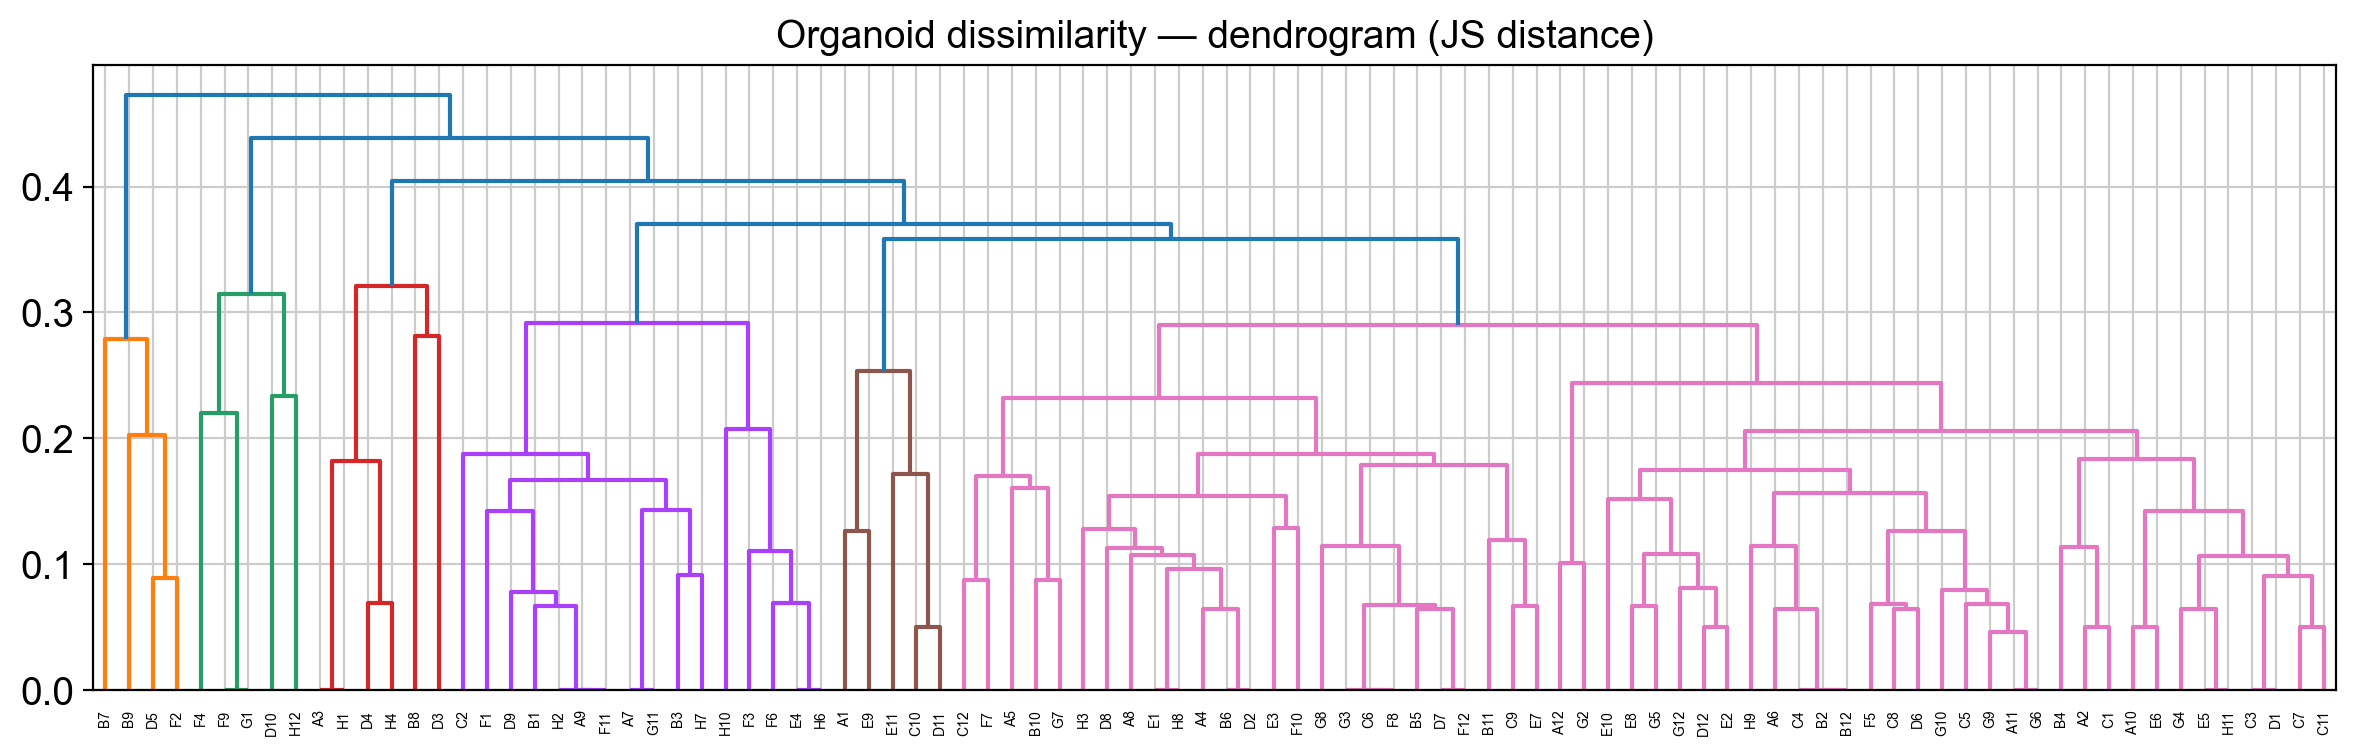

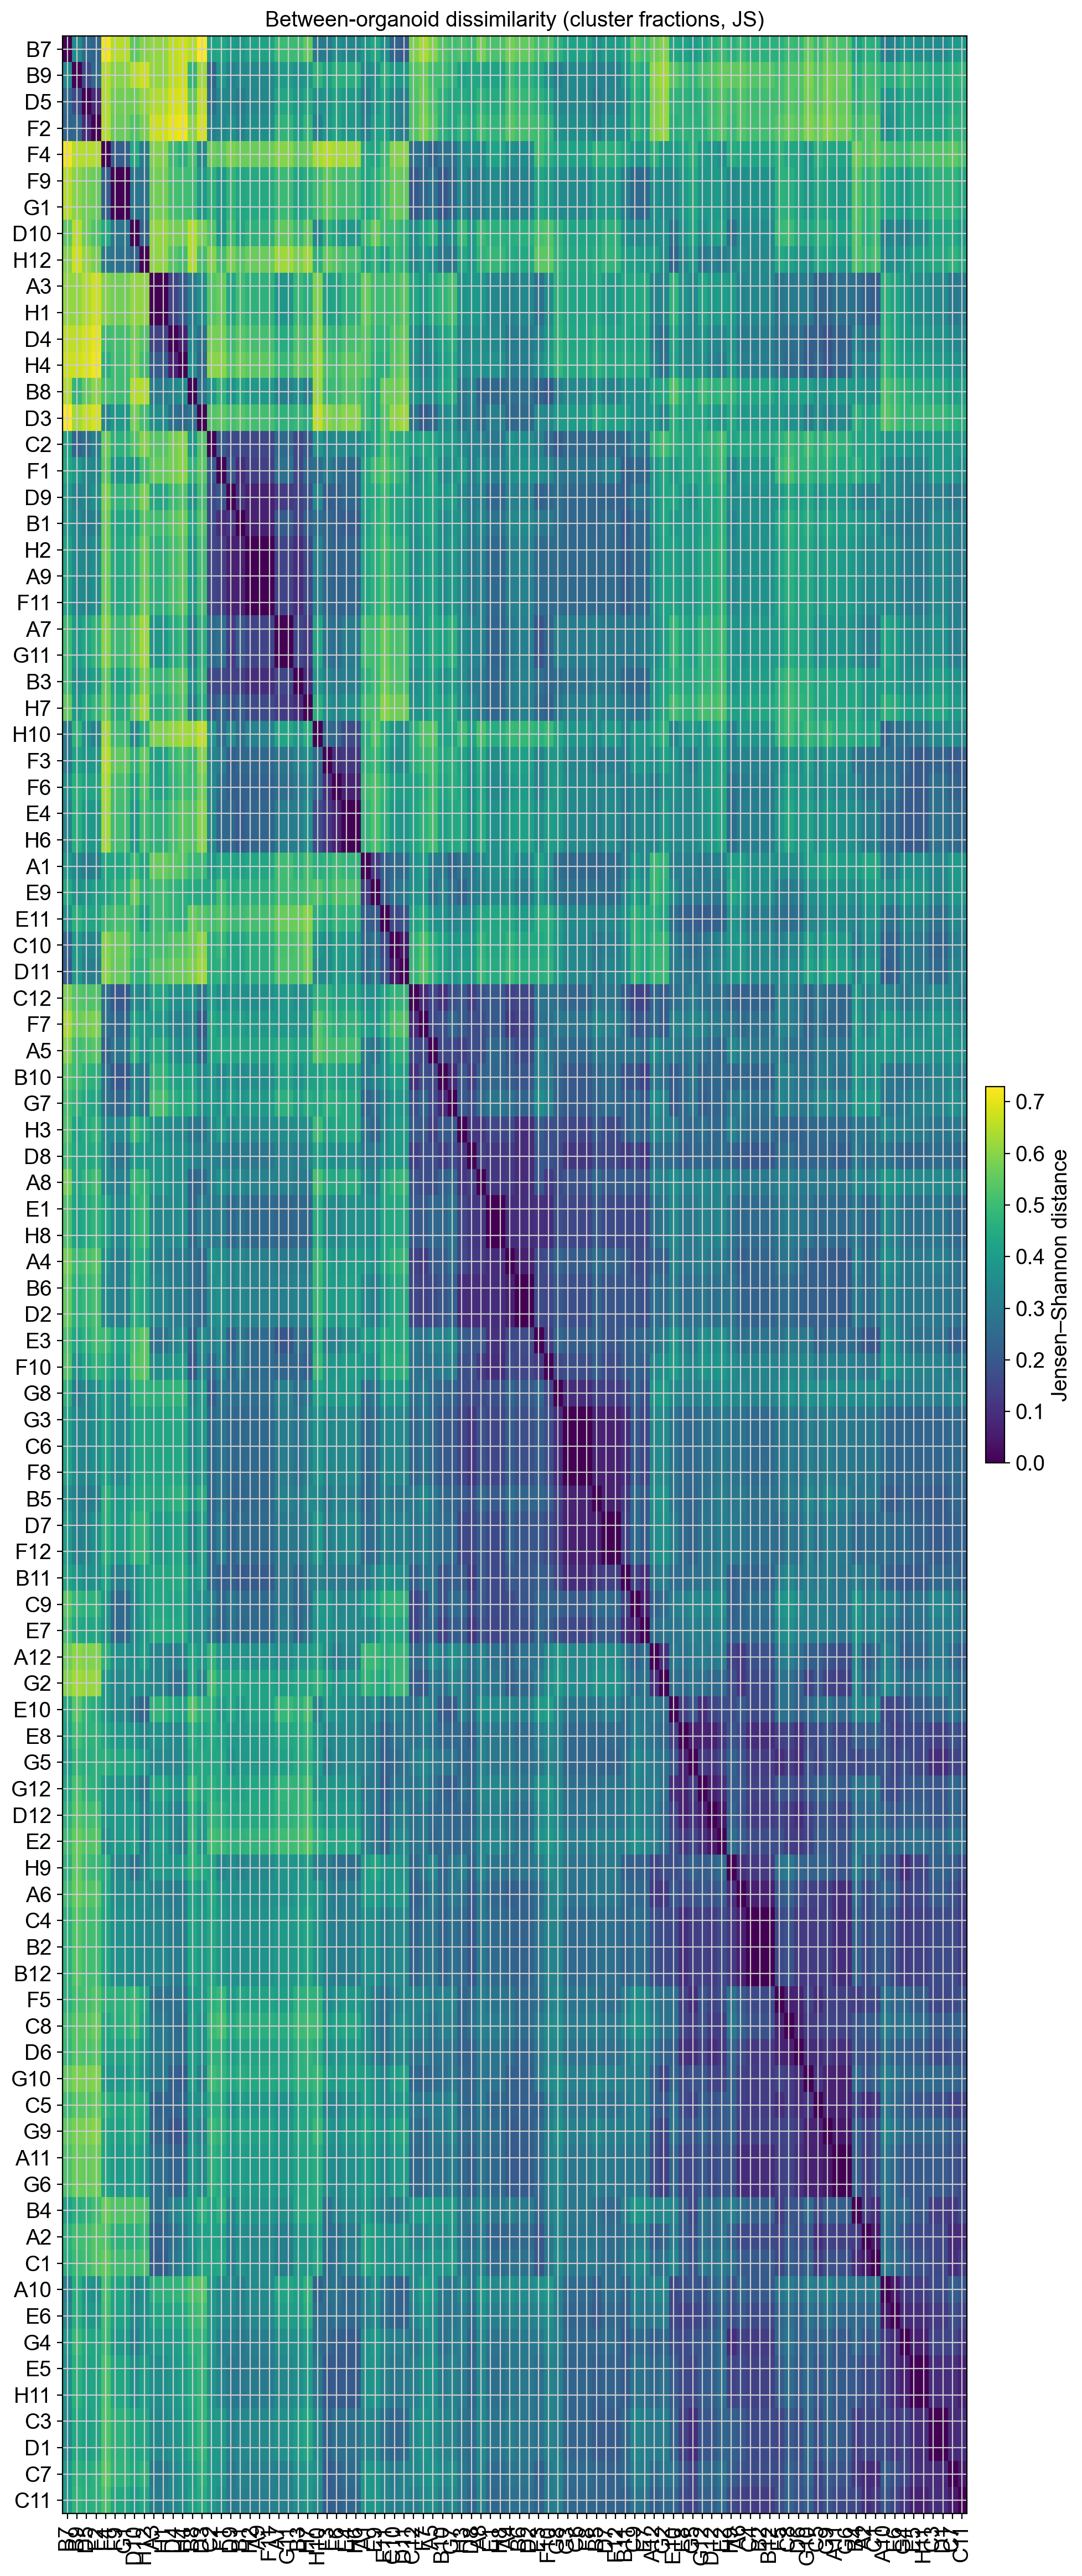

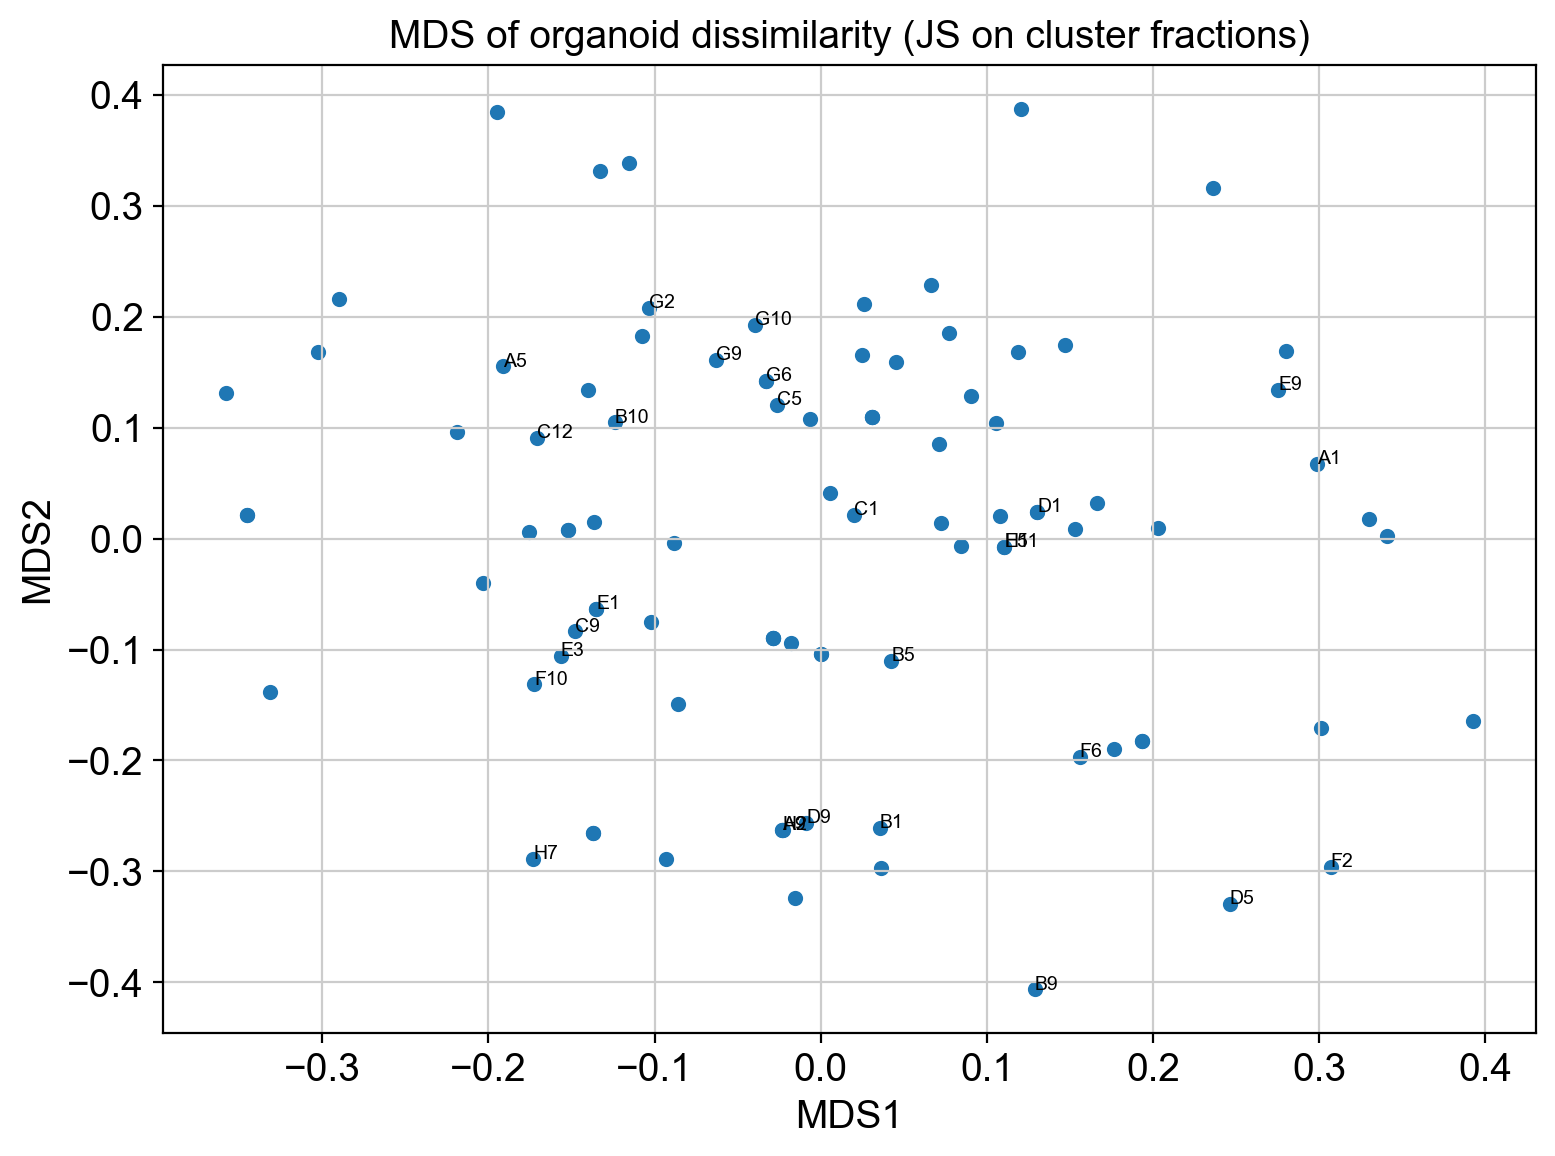

In [33]:
# Cell 7 — Between-organoid dissimilarity (multi-organoid only)
# -------------------------------------------------------------
# What:
# Quantify pairwise differences between organoids based on their cluster compositions using
# Jensen–Shannon distance (JSD), then visualize the organoid landscape with a heatmap+dendrogram
# and a low-dimensional embedding (MDS).
#
# Why:
# - Composition differences (fractions of Leiden-defined states) are a primary source of heterogeneity.
# - JSD provides a symmetric, bounded (0–1) measure of how dissimilar two composition profiles are.
# - Clustering and embedding of the JSD matrix reveal groups of organoids with similar lineage balance.
#
# How:
# - Input: organoid_id × cluster fraction table (same filtering as diversity: require ≥ min_cells_per_org).
# - Smooth zeros with a small epsilon to avoid log(0) in JS computations.
# - Compute pairwise JSD between all kept organoids.
# - Visualize:
#     • Heatmap with hierarchical clustering (dendrogram) to show organoid groupings.
#     • Metric MDS (or t-SNE/UMAP on distances) to display the organoid “atlas” of compositions.
# - Save distance matrix and the dendrogram order for reproducible downstream comparisons.
#
# Outputs:
# - Figures:
#   • figures/nb2_heterogeneity/between/js_heatmap_dendrogram.png
#   • figures/nb2_heterogeneity/between/js_mds.png
# - Tables:
#   • data/processed/nb2_heterogeneity/nb2_organoid_js_distance.csv
#   • data/processed/nb2_heterogeneity/nb2_organoid_js_order.txt
# Notes:
# - Interpret larger JSD as more divergent lineage balance. Close organoids (low JSD) share similar proportions.
# - Use the dendrogram order to align with other summaries (e.g., per-organoid diversity) for side-by-side review.


import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import jensenshannon, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import MDS

# Paths (must match Cell 0)
PROJECT_ROOT = os.getcwd()
PROC_DIR = os.path.join(PROJECT_ROOT, "data", "processed", "nb2_heterogeneity")
FIG_DIR = os.path.join(PROJECT_ROOT, "figures", "nb2_heterogeneity")
os.makedirs(FIG_DIR, exist_ok=True)

# Load embedding checkpoint (from Cell 4)
embed_ckpt_path = os.path.join(PROC_DIR, "nb2_embed.h5ad")
assert os.path.exists(embed_ckpt_path), "Missing nb2_embed.h5ad — run Cell 4 first."
adata = sc.read_h5ad(embed_ckpt_path)

# Parameters
SEED = 1337
cluster_key = "leiden"
org_key = "organoid_id"
min_cells_per_org = 6
pseudocount = 1e-9  # smoothing for JS

# Composition (organoid x cluster) and filtering
ct = pd.crosstab(adata.obs[org_key], adata.obs[cluster_key])
sizes = ct.sum(1)
ct = ct.loc[sizes >= min_cells_per_org]
sizes = sizes.loc[sizes >= min_cells_per_org]

# Fractions (rows sum to 1)
p = ct.div(ct.sum(1), axis=0).astype(float)
p = p + pseudocount
p = p.div(p.sum(1), axis=0)

orgs = p.index.tolist()
P = p.values  # (n_org x n_clusters)

# Pairwise Jensen–Shannon distance matrix
n = P.shape[0]
D = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(i + 1, n):
        D[i, j] = D[j, i] = jensenshannon(P[i], P[j])  # already returns sqrt(JS divergence)

# Save distance matrix
dist_csv = os.path.join(PROC_DIR, "nb2_organoid_js_distance.csv")
pd.DataFrame(D, index=orgs, columns=orgs).to_csv(dist_csv)

# Hierarchical clustering (average linkage on precomputed distances)
Z = linkage(squareform(D), method="average")
# Dendrogram to get ordering
plt.figure(figsize=(12, 4))
dn = dendrogram(Z, labels=orgs, leaf_rotation=90)
plt.title("Organoid dissimilarity — dendrogram (JS distance)")
plt.tight_layout()
savefig(plt.gcf(), "js_dendrogram", subdir="between")

# Heatmap ordered by dendrogram leaves
order = dn["ivl"]
order_idx = [orgs.index(o) for o in order]
D_ord = D[np.ix_(order_idx, order_idx)]

plt.figure(figsize=(10, max(6, 0.25 * len(order))))
im = plt.imshow(D_ord, aspect="auto", interpolation="nearest")
plt.colorbar(im, fraction=0.02, pad=0.02, label="Jensen–Shannon distance")
plt.xticks(range(len(order)), order, rotation=90)
plt.yticks(range(len(order)), order)
plt.title("Between-organoid dissimilarity (cluster fractions, JS)")
plt.tight_layout()
savefig(plt.gcf(), "js_heatmap_dendrogram", subdir="between")

# 2D MDS embedding from distance matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=SEED, normalized_stress='auto')
X2 = mds.fit_transform(D)

plt.figure(figsize=(8, 6))
plt.scatter(X2[:, 0], X2[:, 1], s=20)
for i, name in enumerate(orgs):
    # label a subset to keep plot readable: largest organoids or every ~5th point
    if sizes.loc[name] == sizes.max() or (i % max(1, len(orgs)//20) == 0):
        plt.text(X2[i, 0], X2[i, 1], name, fontsize=7)
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.title("MDS of organoid dissimilarity (JS on cluster fractions)")
plt.tight_layout()
savefig(plt.gcf(), "js_mds", subdir="between")

# Save order for reproducibility
order_txt = os.path.join(PROC_DIR, "nb2_organoid_js_order.txt")
with open(order_txt, "w") as f:
    f.write("\n".join(order))

# Console summary
print(f"[between] Organoids used: {n} (>= {min_cells_per_org} cells).")
print(f"[between] Distance matrix → {os.path.relpath(dist_csv)}")
print(f"[between] Dendrogram/heatmap order → {os.path.relpath(order_txt)}")
print("[between] Figures saved under figures/nb2_heterogeneity/between/")
print("Step 9 complete — between-organoid dissimilarity computed and visualized.")


In [ ]:
# Interpretation — Cell 7 (Between-organoid dissimilarity)
# --------------------------------------------------------
# Biological reading:
# - Tight organoid clusters on the heatmap/MDS reflect replicates with similar mixes of progenitors,
#   intermediate progenitors, and neurons—i.e., comparable maturation trajectories.
# - Outlier organoids (high average JSD) likely over- or under-represent a lineage (e.g., neuron-skewed vs progenitor-skewed),
#   consistent with known variability in cerebral organoid patterning and maturation.
#
# Heterogeneity framework:
# - Level: Between-organoid heterogeneity in composition (distance between profiles).
# - Mode: Global structure (clusters of organoids) and extremeness (outliers).
# - Implication: Organism-level comparisons or perturbation studies should control for this axis of variability;
#   select matched organoids (low pairwise JSD) when building case–control contrasts.
#
# Practical guidance:
# - Cross-reference organoids’ diversity scores (Cell 6) with their JSD neighborhoods:
#   high-diversity organoids often sit near the center of the MDS map; low-diversity outliers drift to the periphery.
# - Use the dendrogram order to guide representative selection: pick 2–3 organoids from each major branch
#   for downstream differential analyses or marker validation.


[savefig] Saved → figures/nb2_heterogeneity/concordance/hist_same_org_fraction.png
[savefig] Saved → figures/nb2_heterogeneity/concordance/scatter_sameorg_vs_size.png
[concordance] Organoids: 96 | Cells: 734 | kNN: 15
[concordance] Overall silhouette by organoid (UMAP): -0.367
[concordance] Best-mixing organoids (lowest mean same-org frac):
             n_cells  mean_same_org_frac  mean_neighbor_entropy  mean_silhouette
organoid_id                                                                     
A1                 8               0.000                  2.577           -0.381
F7                 9               0.000                  2.595           -0.395
F6                 6               0.000                  2.590           -0.404
F5                 7               0.000                  2.568           -0.282
F1                 7               0.000                  2.582           -0.414
[concordance] Worst-mixing organoids (highest mean same-org frac):
             n_cells  m

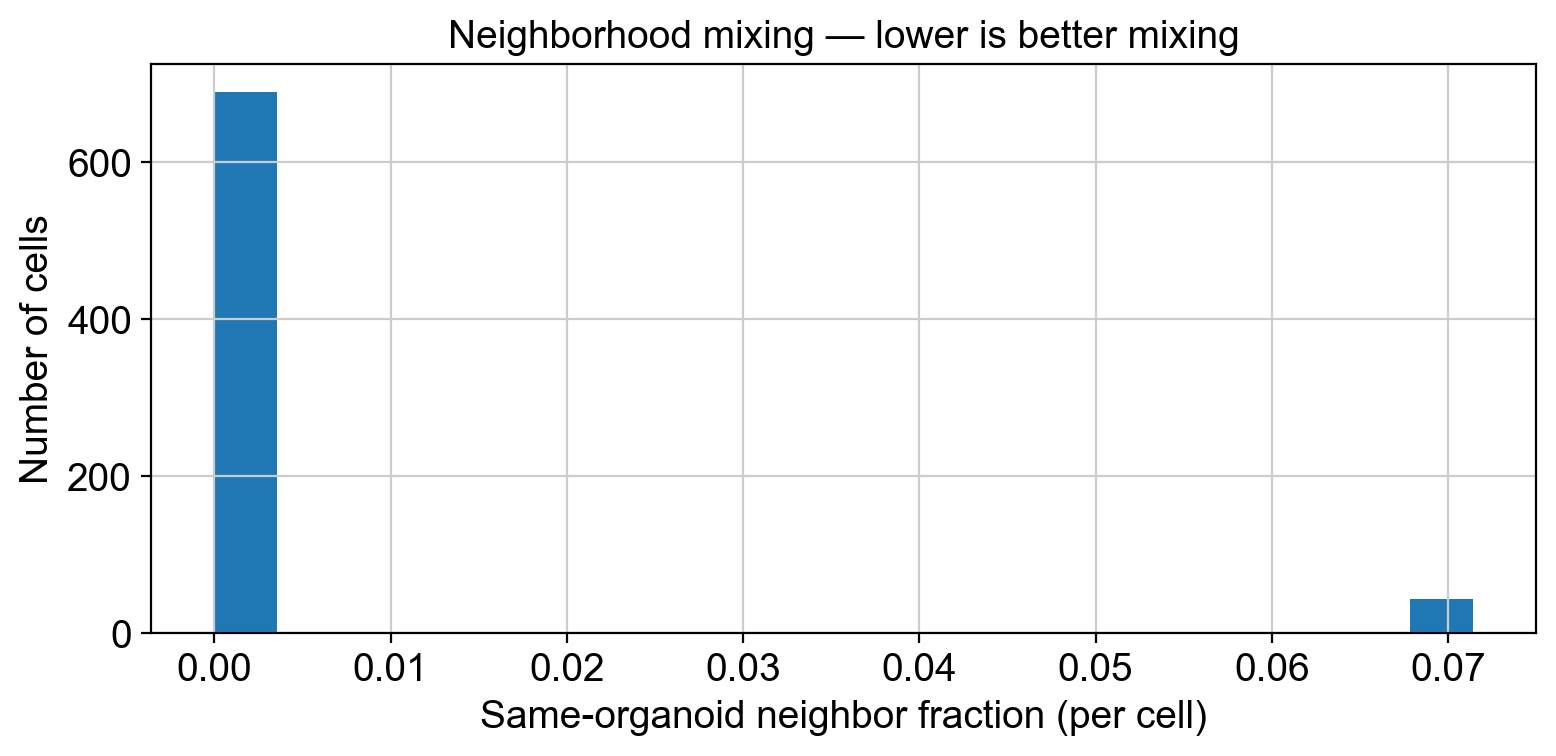

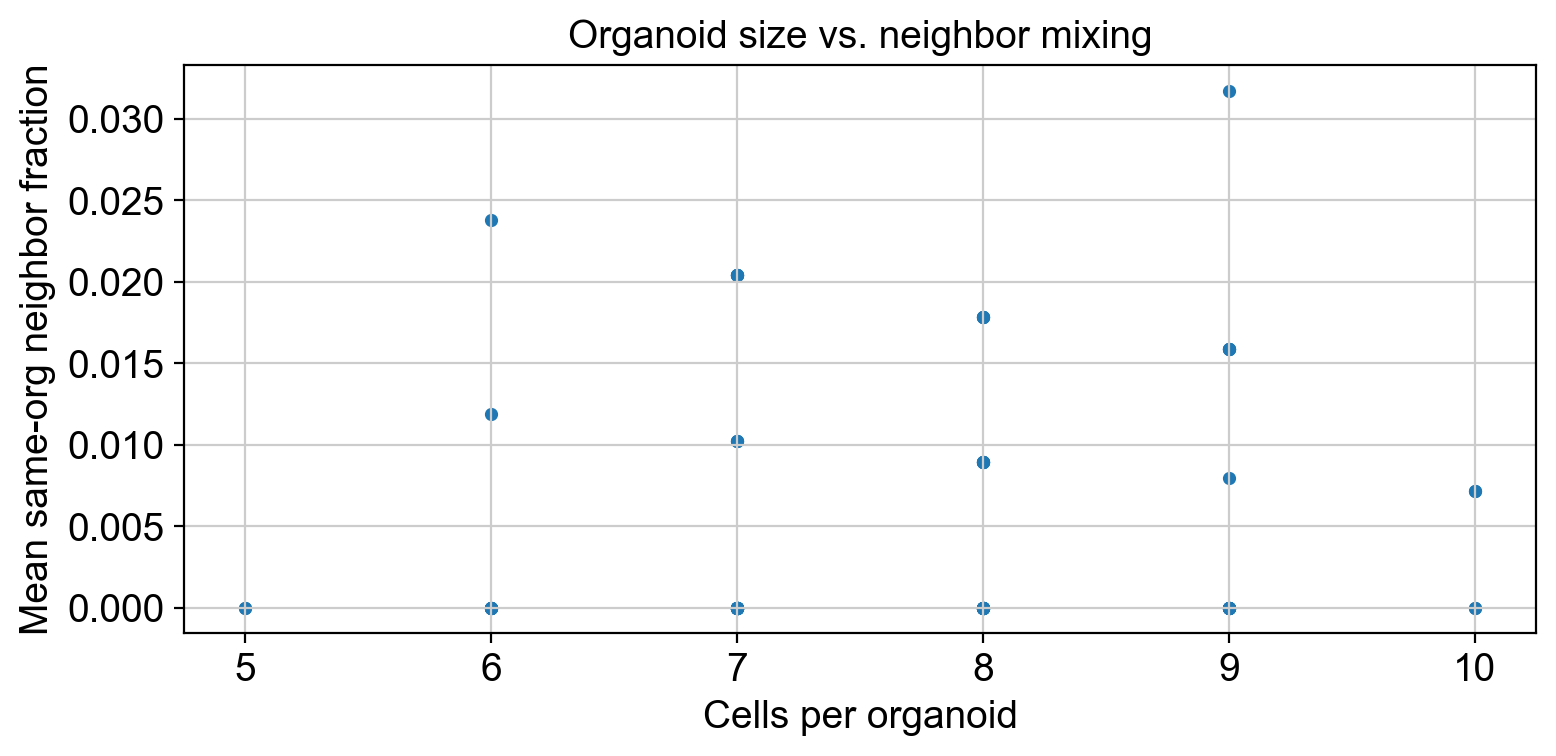

In [41]:
# Cell 8 — Embedding concordance (organoid mixing in neighbor graph)
# ------------------------------------------------------------------
# What:
# Quantify how well cells from different organoids mix in the low-dimensional space (UMAP/PCA kNN graph).
#
# Why:
# - If organoids share the same biological states, neighbors should be drawn from multiple organoids.
# - Poor mixing (neighbors from the same organoid) may indicate batch effects or organoid-specific drifts.
#
# How:
# - Build a kNN graph in the embedding space used in Cell 4 (e.g., UMAP; n_neighbors=15, seed=1337).
# - Compute per-cell metrics:
#     (A) Same-organoid neighbor fraction (lower = better mixing).
#     (B) Neighbor-label entropy over organoid_id (higher = better mixing).
#     (C) Silhouette score using organoid_id labels in UMAP space (more negative = better mixing).
# - Aggregate per organoid: mean of each metric; report global silhouette.
# - Visualize:
#     • Histogram of per-cell same-organoid fraction.
#     • (Optional) Scatter vs organoid size; barplot of top/bottom organoids by mixing.
# - Save per-cell and per-organoid tables for downstream QC/selection.
#
# Outputs:
# - Figures:
#   • figures/nb2_heterogeneity/concordance/hist_same_org_fraction.png
#   • figures/nb2_heterogeneity/concordance/scatter_sameorg_vs_size.png   # optional; hide if empty/uninformative
#   • figures/nb2_heterogeneity/concordance/bar_mean_sameorg_topN.png     # optional; hide if empty/uninformative
# - Tables:
#   • data/processed/nb2_heterogeneity/nb2_concordance_per_cell.parquet
#   • data/processed/nb2_heterogeneity/nb2_concordance_per_organoid.csv
# Notes:
# - Skip if single-organoid dataset.
# - Match n_neighbors to Cell 4 for consistency; consider sensitivity checks (10–30).


import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score
from collections import Counter

# Paths (match Cell 0)
PROJECT_ROOT = os.getcwd()
PROC_DIR = os.path.join(PROJECT_ROOT, "data", "processed", "nb2_heterogeneity")
FIG_DIR = os.path.join(PROJECT_ROOT, "figures", "nb2_heterogeneity")
os.makedirs(FIG_DIR, exist_ok=True)

# Load embedding checkpoint (from Cell 4)
embed_ckpt_path = os.path.join(PROC_DIR, "nb2_embed.h5ad")
assert os.path.exists(embed_ckpt_path), "Missing nb2_embed.h5ad — run Cell 4 first."
adata = sc.read_h5ad(embed_ckpt_path)

SEED = 1337
org_key = "organoid_id"
cluster_key = "leiden"
assert org_key in adata.obs.columns, f"Missing {org_key} in adata.obs"

n_org = adata.obs[org_key].nunique()
if n_org < 2:
    print("[concordance] Single-organoid mode detected — skipping Cell 10.")
else:
    # ---------------------------
    # Neighborhoods in UMAP space
    # ---------------------------
    if "X_umap" not in adata.obsm_keys():
        raise ValueError("X_umap not found. Please run Cell 4 (neighbors/UMAP).")
    X = adata.obsm["X_umap"]
    n_neighbors = int(adata.uns.get("neighbors", {}).get("params", {}).get("n_neighbors", 15))

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto", n_jobs=-1)
    nbrs.fit(X)
    # include self in neighbors; we will remove self later
    distances, indices = nbrs.kneighbors(X, return_distance=True)

    org = adata.obs[org_key].astype("category").values
    org_codes = adata.obs[org_key].astype("category").cat.codes.values
    n = X.shape[0]

    same_frac = np.zeros(n, dtype=float)
    entropies = np.zeros(n, dtype=float)

    # helper: entropy over discrete labels
    def _entropy_from_counts(counts):
        p = counts / counts.sum()
        p = p[p > 0]
        return -(p * np.log(p)).sum()

    for i in range(n):
        neigh = indices[i]
        # drop self if present
        neigh = neigh[neigh != i]
        neigh_org = org[neigh]
        same = (neigh_org == org[i]).mean() if len(neigh_org) > 0 else np.nan
        same_frac[i] = same

        # entropy over organoid labels in neighborhood
        c = Counter(neigh_org)
        counts = np.fromiter(c.values(), dtype=float)
        entropies[i] = _entropy_from_counts(counts) if counts.size > 0 else np.nan

    # Silhouette (by organoid) in UMAP space
    # Only compute if at least two organoids
    sil_per_cell = silhouette_samples(X, org_codes, metric="euclidean") if n_org >= 2 else np.zeros(n)
    sil_overall = silhouette_score(X, org_codes, metric="euclidean") if n_org >= 2 else np.nan

    # ---------------------------
    # Aggregate per organoid
    # ---------------------------
    df_cell = pd.DataFrame({
        "organoid_id": adata.obs[org_key].values,
        "same_org_neighbor_fraction": same_frac,
        "neighbor_entropy": entropies,
        "silhouette_organoid": sil_per_cell
    }, index=adata.obs_names)

    per_org = df_cell.groupby("organoid_id").agg(
        n_cells=("same_org_neighbor_fraction", "size"),
        mean_same_org_frac=("same_org_neighbor_fraction", "mean"),
        median_same_org_frac=("same_org_neighbor_fraction", "median"),
        mean_neighbor_entropy=("neighbor_entropy", "mean"),
        median_neighbor_entropy=("neighbor_entropy", "median"),
        mean_silhouette=("silhouette_organoid", "mean"),
        median_silhouette=("silhouette_organoid", "median"),
    ).sort_values("mean_same_org_frac", ascending=True)  # ascending: best mixing first

    # ---------------------------
    # Plots
    # ---------------------------
    os.makedirs(os.path.join(FIG_DIR, "concordance"), exist_ok=True)

    # (1) Histogram of per-cell same-org neighbor fraction
    plt.figure(figsize=(8,4))
    plt.hist(df_cell["same_org_neighbor_fraction"].dropna(), bins=20)
    plt.xlabel("Same-organoid neighbor fraction (per cell)")
    plt.ylabel("Number of cells")
    plt.title("Neighborhood mixing — lower is better mixing")
    plt.tight_layout()
    savefig(plt.gcf(), "hist_same_org_fraction", subdir="concordance")

    # (2) Scatter: organoid size vs mean same-org fraction
    plt.figure(figsize=(8,4))
    plt.scatter(per_org["n_cells"], per_org["mean_same_org_frac"], s=14)
    plt.xlabel("Cells per organoid")
    plt.ylabel("Mean same-org neighbor fraction")
    plt.title("Organoid size vs. neighbor mixing")
    plt.tight_layout()
    savefig(plt.gcf(), "scatter_sameorg_vs_size", subdir="concordance")

    # ---------------------------
    # Save artifacts
    # ---------------------------
    per_cell_path = os.path.join(PROC_DIR, "nb2_concordance_per_cell.parquet")
    df_cell.to_parquet(per_cell_path)
    per_org_path = os.path.join(PROC_DIR, "nb2_concordance_per_organoid.csv")
    per_org.to_csv(per_org_path)

    # ---------------------------
    # Console summary
    # ---------------------------
    print(f"[concordance] Organoids: {n_org} | Cells: {n} | kNN: {n_neighbors}")
    print(f"[concordance] Overall silhouette by organoid (UMAP): {sil_overall:.3f}")
    print("[concordance] Best-mixing organoids (lowest mean same-org frac):")
    print(per_org.head(5)[["n_cells","mean_same_org_frac","mean_neighbor_entropy","mean_silhouette"]]
          .to_string(float_format=lambda x: f"{x:.3f}"))
    print("[concordance] Worst-mixing organoids (highest mean same-org frac):")
    print(per_org.tail(5)[["n_cells","mean_same_org_frac","mean_neighbor_entropy","mean_silhouette"]]
          .to_string(float_format=lambda x: f"{x:.3f}"))
    print(f"[concordance] Saved per-cell → {os.path.relpath(per_cell_path)}")
    print(f"[concordance] Saved per-organoid → {os.path.relpath(per_org_path)}")
    print("Step 10 complete — embedding concordance computed and visualized.")


In [ ]:
# Interpretation — Cell 8 (Embedding concordance / organoid mixing)
# -----------------------------------------------------------------
# Readout:
# - A left-shifted histogram of same-organoid neighbor fraction (peaking near 0) indicates strong cross-organoid mixing.
# - Higher neighbor-label entropy and negative global silhouette (by organoid_id) support the same conclusion.
# - Organids with higher mean same-org fraction (or low entropy) are potential outliers worth inspecting.
#
# Biological lens (GSE75140 cerebral organoids):
# - Good mixing implies that major cortical states (radial glia → intermediate progenitors → neurons) are shared
#   across organoids; differences observed later are likely *compositional* rather than new organoid-specific states.
# - Poorly mixing organoids may reflect maturation offsets (e.g., neuron-skewed vs progenitor-skewed),
#   culture variability, or residual technical artifacts.
#
# Framework guidance:
# - Level: Cross-organoid alignment of shared states in the embedding.
# - Mode: Consistency check—supports interpreting between-organoid variability as shifts in proportions (Cells 5–7).
# - Implication: Use these metrics to (i) flag organoids for exclusion or sensitivity analysis and
#   (ii) stratify organoids when comparing conditions (match organoids with similar mixing profiles).
#
# Practical use:
# - If global silhouette is near 0 or negative and entropy is high, proceed confidently with diversity and JSD analyses.
# - If specific organoids show poor mixing, consider rerunning neighbors/UMAP with adjusted parameters,
#   regressing known covariates, or analyzing those organoids separately.


[intra-type] Using Leiden clusters as proxy for cell types.
[intra-type] Candidate types (>= 40 cells, top 6): ['0', '1', '2', '3', '4']
[intra-type] '0': cells=203, organoids=91
[savefig] Saved → figures/nb2_heterogeneity/intra_type/hist_same_org_fraction_0.png
[savefig] Saved → figures/nb2_heterogeneity/intra_type/scatter_size_vs_sameorgpct_0.png
[intra-type] '0' silhouette by organoid (UMAP): -0.671
[intra-type] '0' per-organoid (lowest mean same-org first):
             n_cells  mean_same_org_frac
organoid_id                             
A1                 2               0.000
F12                3               0.000
F11                2               0.000
F10                3               0.000
F1                 1               0.000
E9                 3               0.000
E8                 2               0.000
E7                 1               0.000
E6                 2               0.000
E5                 3               0.000
[intra-type] Saved → data/processed/nb2_he

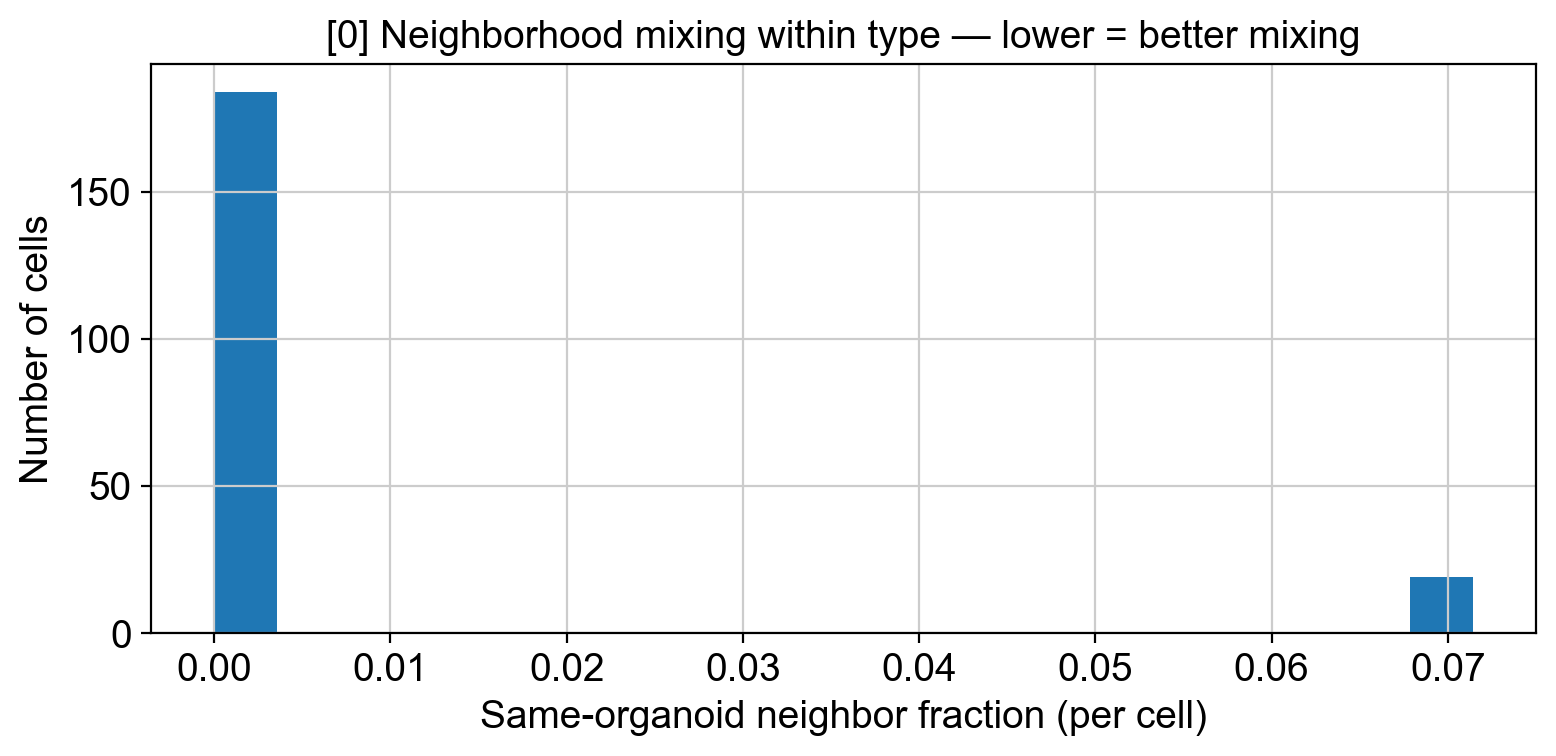

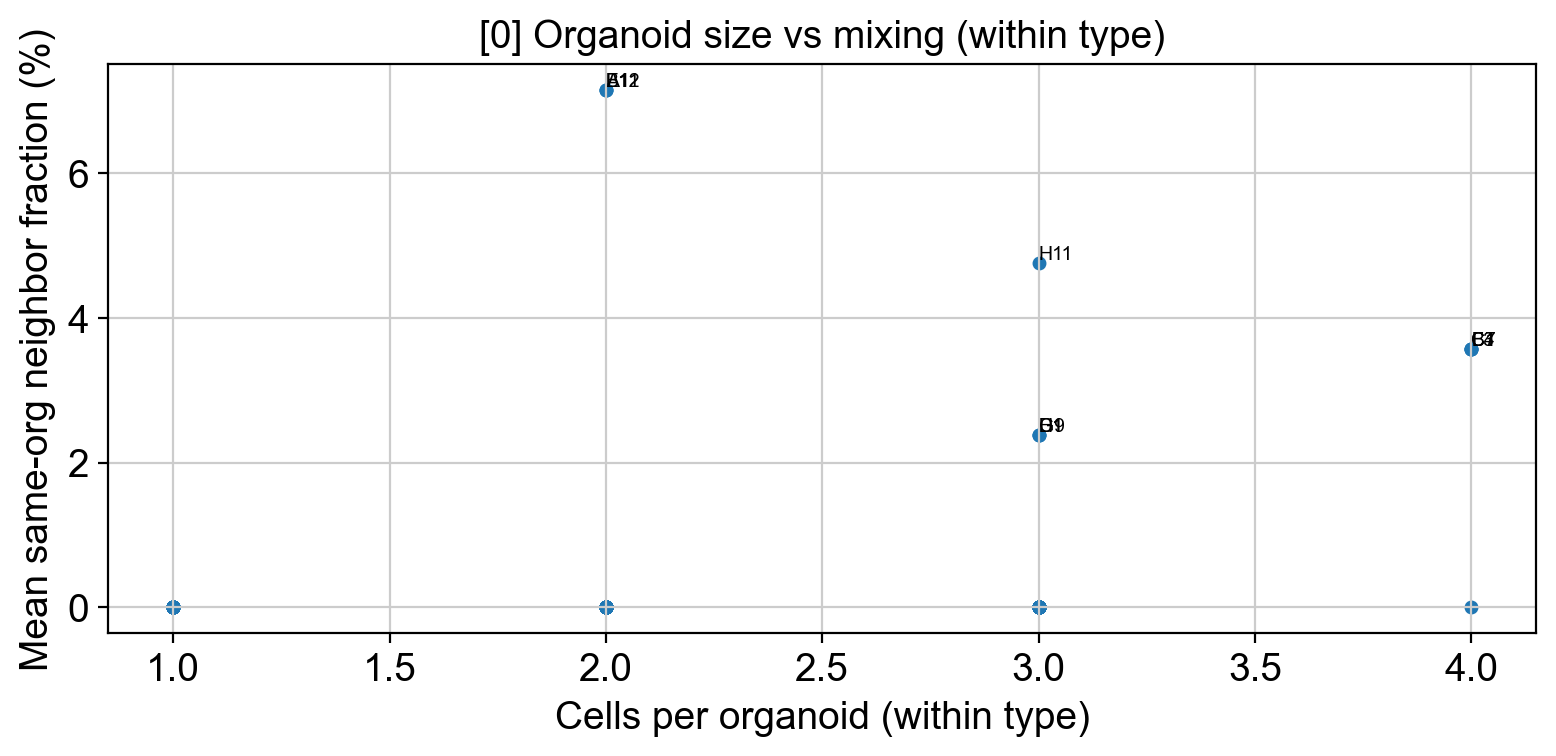

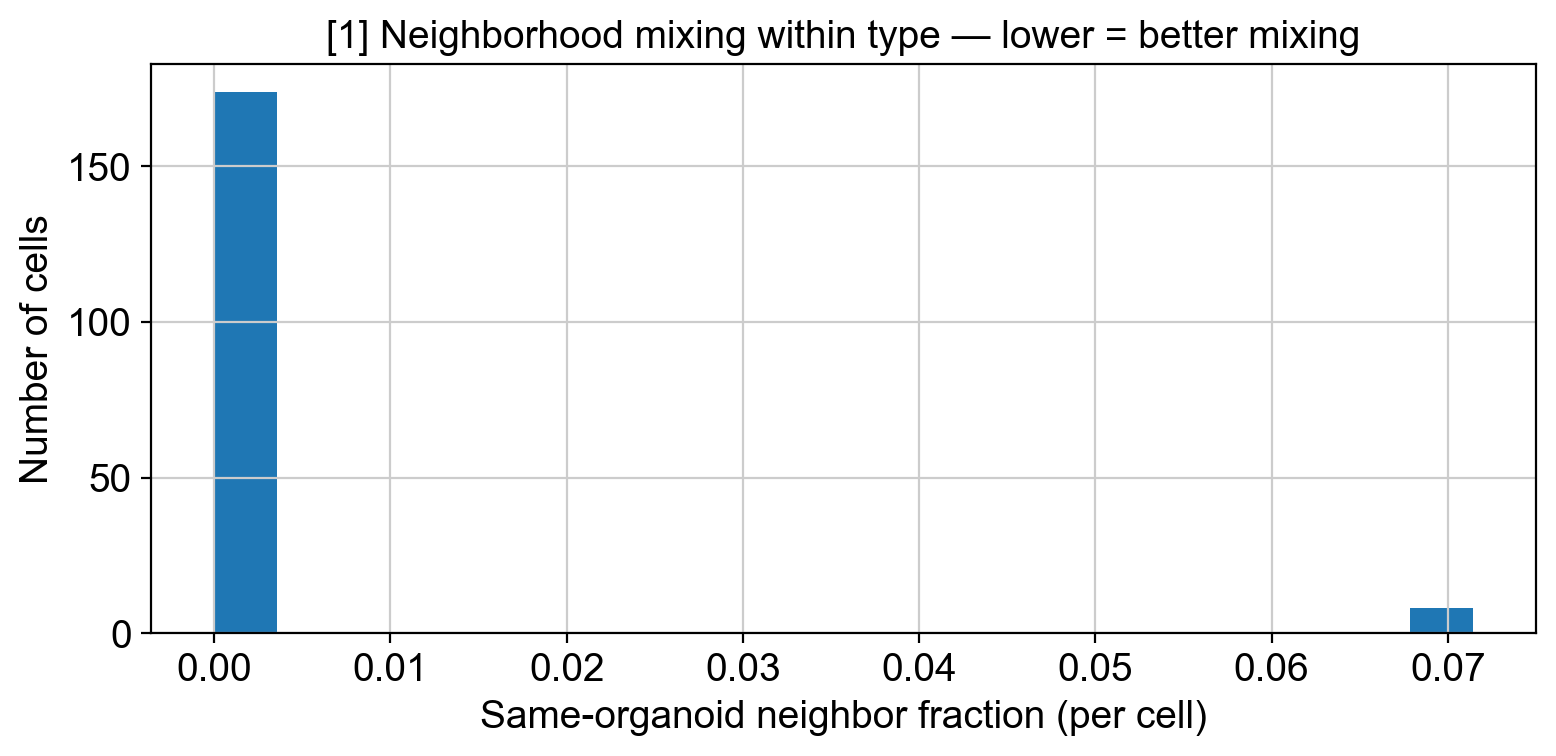

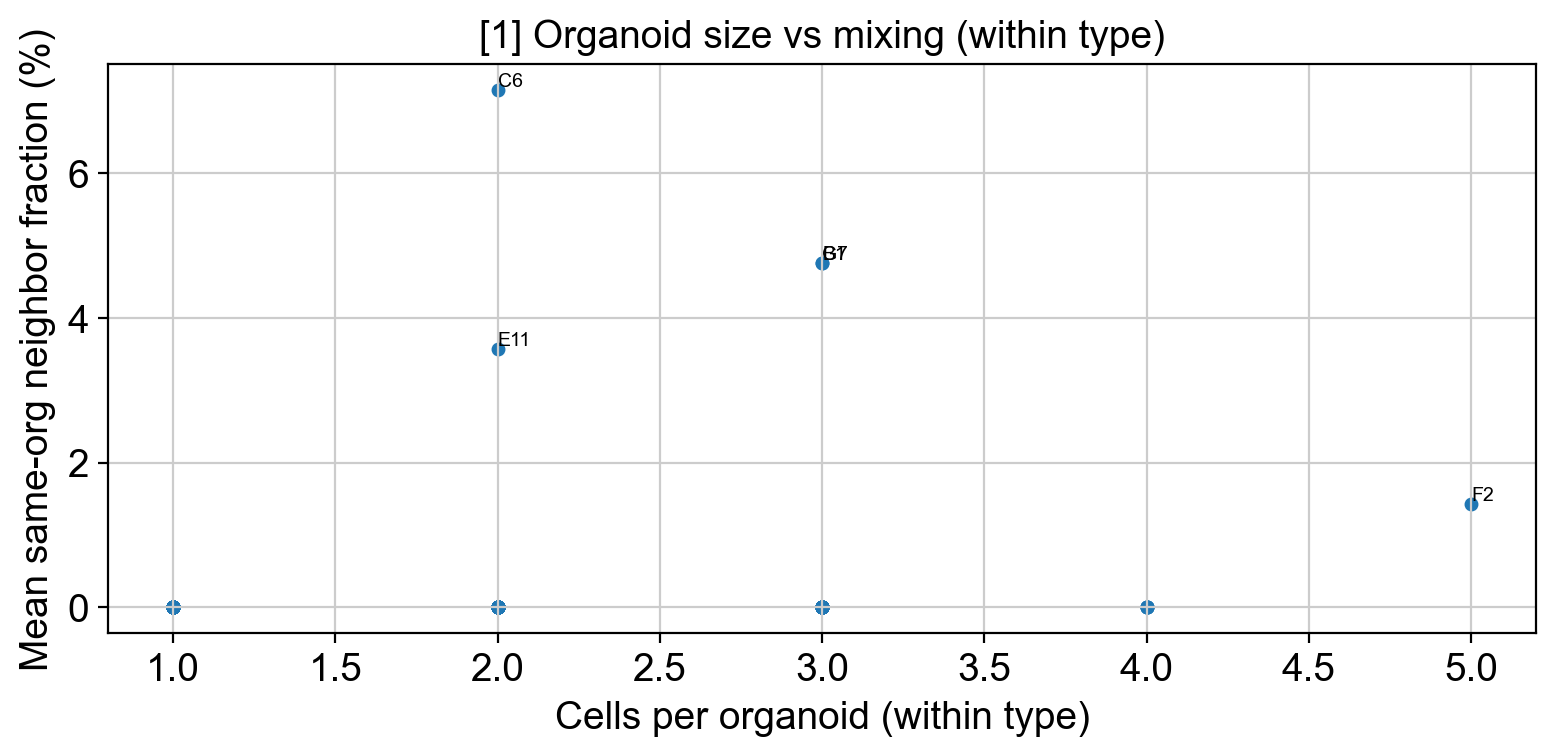

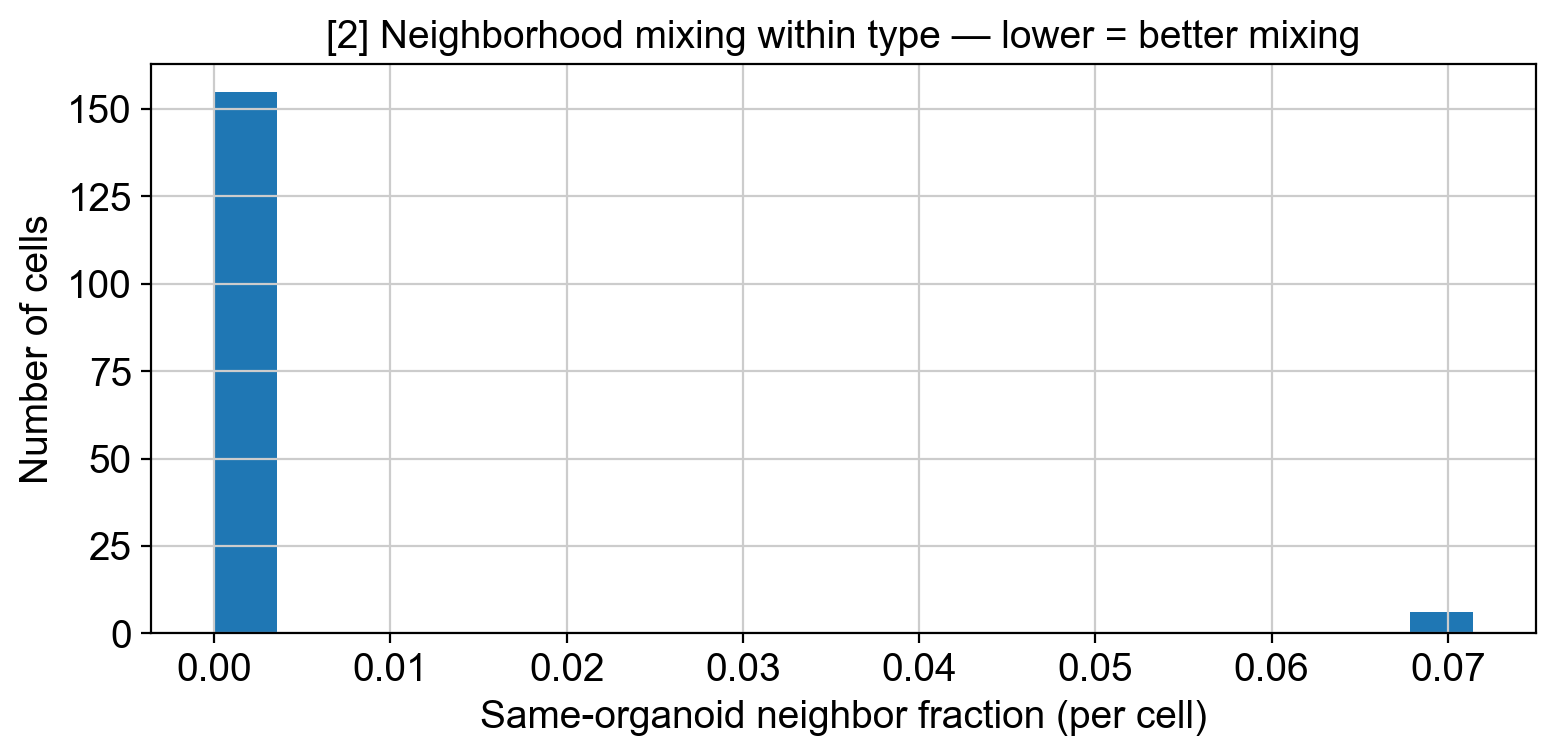

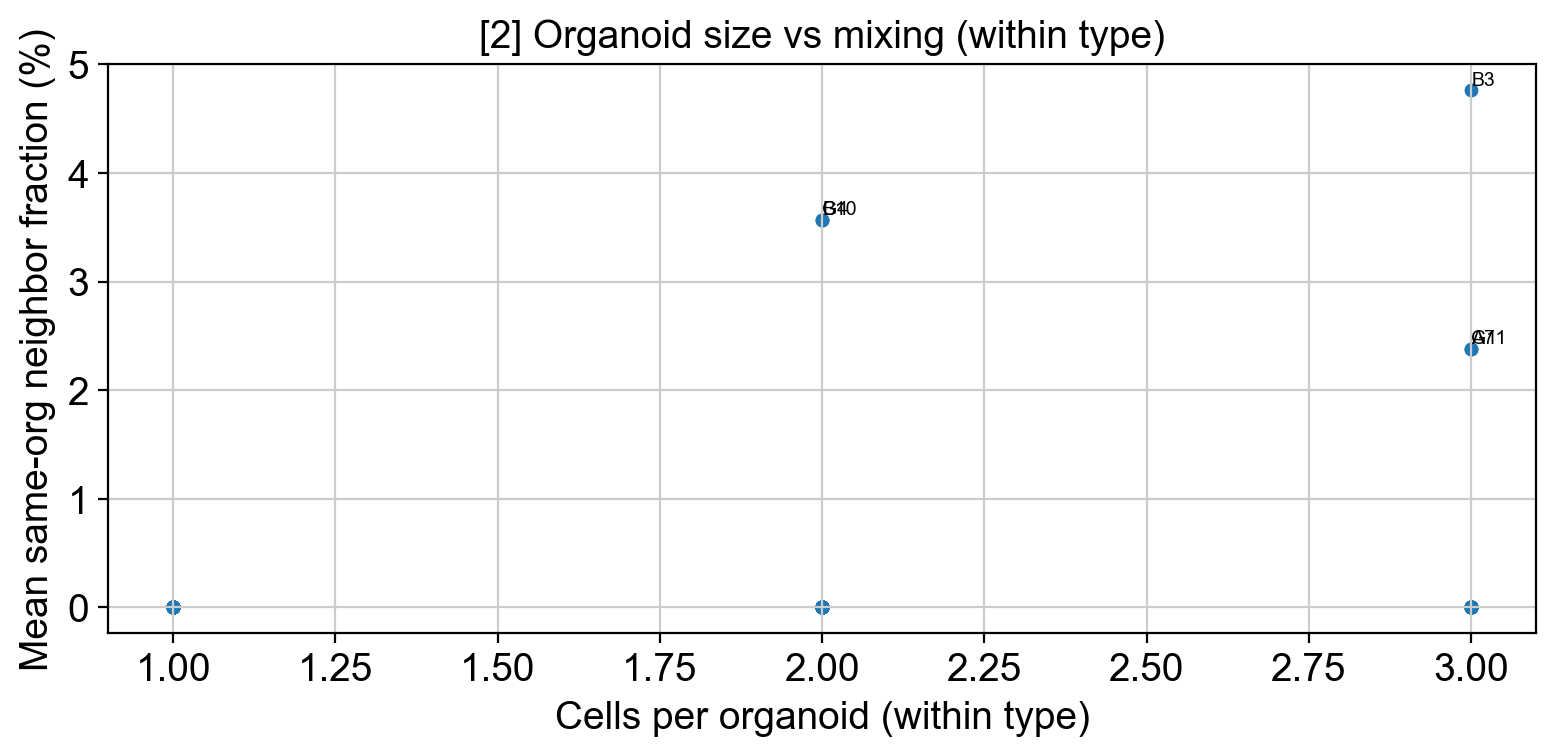

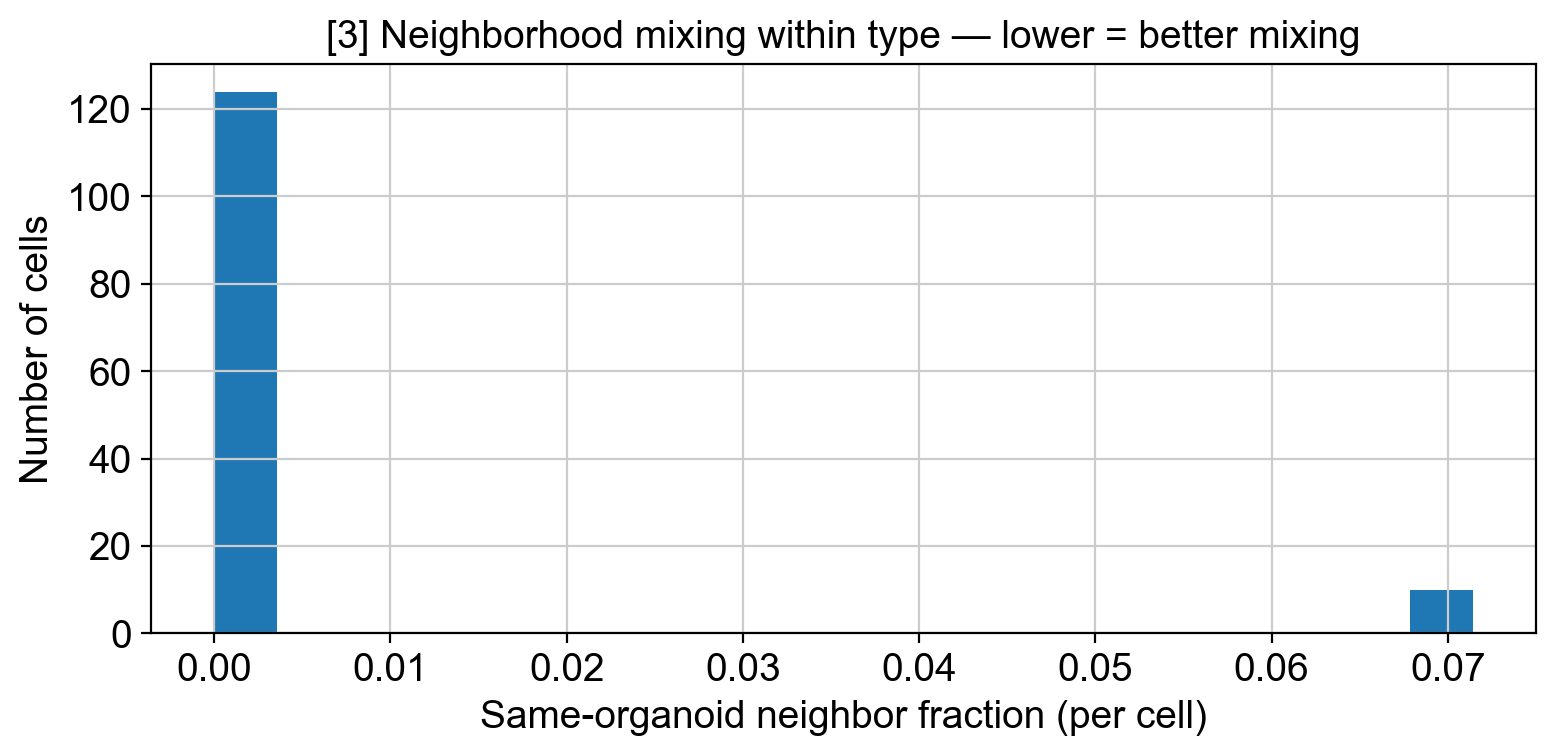

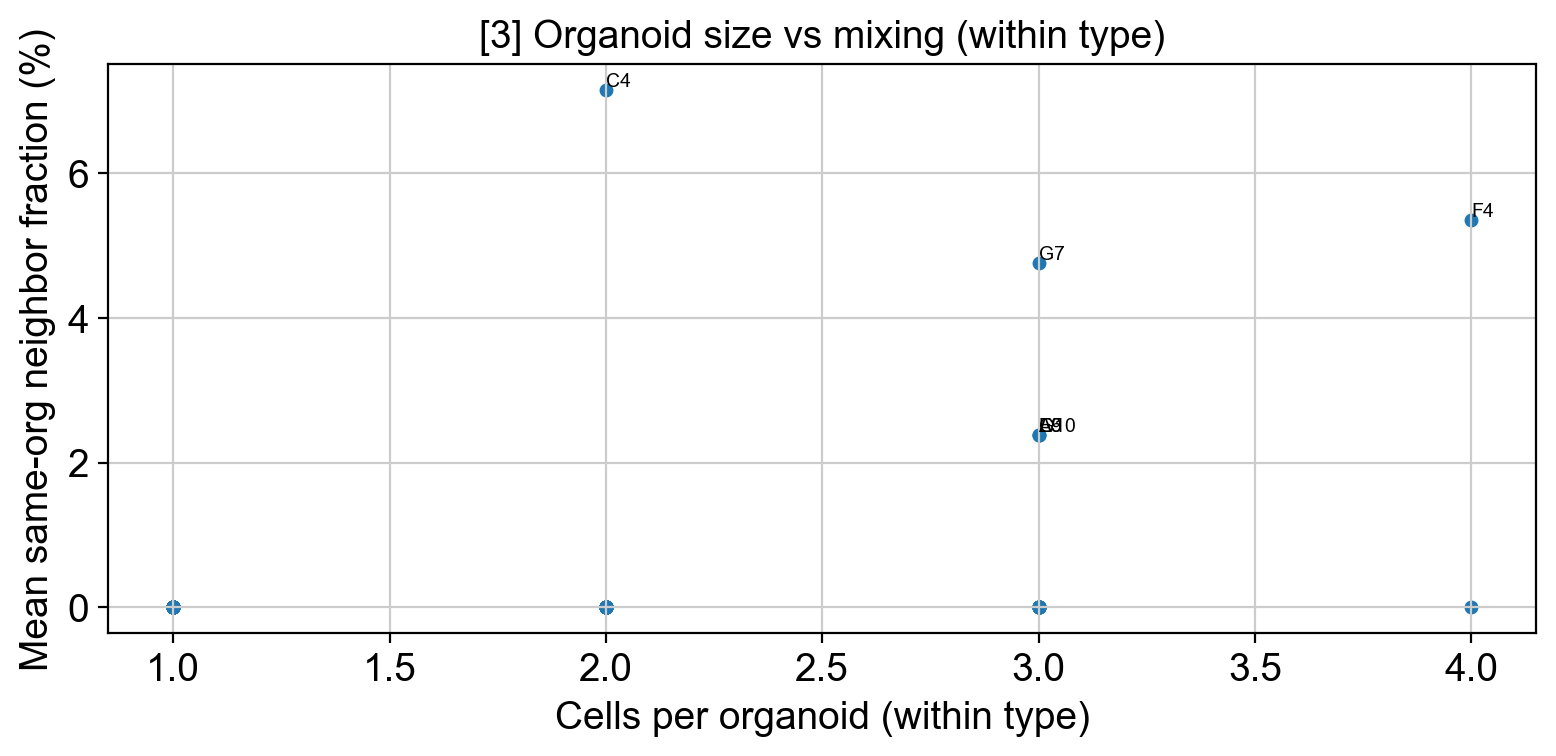

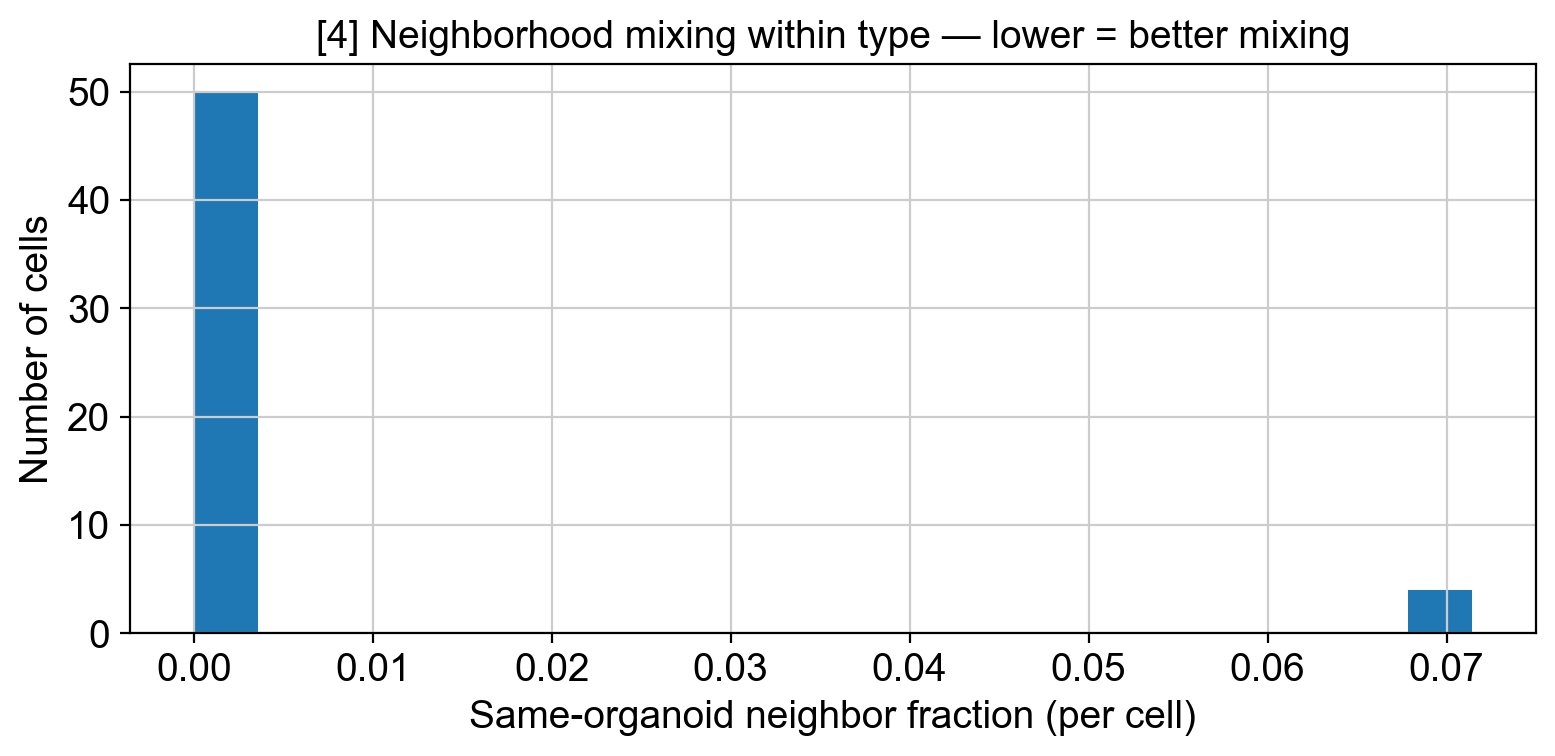

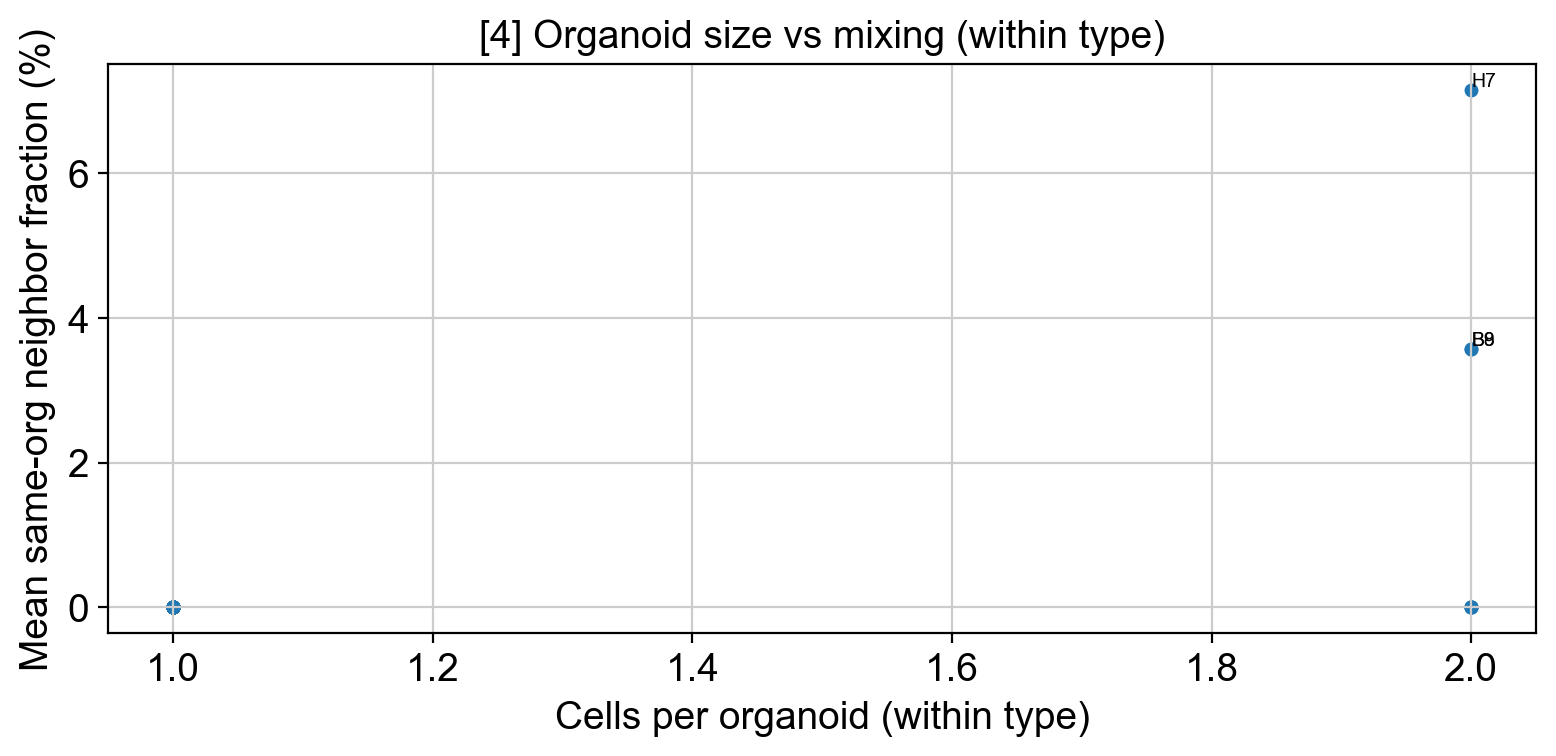

In [42]:
# Cell 9 — Intra–cell-type heterogeneity (per-type mixing across organoids)
# --------------------------------------------------------------------------
# What:
# Within each major cell type (or Leiden cluster if no annotations), assess how well cells from
# different organoids mix in the local neighborhood graph and summarize organoid-specific deviations.
#
# Why:
# - Separates *composition differences* from *state differences*. If organoids also mix well *within*
#   a given type, heterogeneity is mostly proportionality (how much of each type). If not, some
#   organoids harbor distinct sub-states or maturation shifts inside a type.
#
# How:
# - For each type with sufficient cells (e.g., ≥ 40 total):
#   • Subset adata to cells of that type and use the existing UMAP (or recompute neighbors if needed).
#   • Compute per-cell same-organoid neighbor fraction and silhouette by organoid_id inside the subset.
#   • Aggregate per organoid (mean same-org fraction) and report per-type summaries.
# - Visualize per type:
#   • Histogram of per-cell same-org fraction.
#   • Scatter: organoid size (n cells of this type) vs mean same-org % (optional if uninformative).
# - Save per-type CSVs (per-cell, per-organoid) and one summary table across types.
#
# Outputs:
# - Figures (per type):
#   • figures/nb2_heterogeneity/intra_type/hist_same_org_fraction_<type>.png
#   • figures/nb2_heterogeneity/intra_type/scatter_size_vs_sameorgpct_<type>.png
# - Tables:
#   • data/processed/nb2_heterogeneity/nb2_intratypemix_<type>_per_cell.csv
#   • data/processed/nb2_heterogeneity/nb2_intratypemix_<type>_per_org.csv
#   • data/processed/nb2_heterogeneity/nb2_intratypemix_summary.csv
# Notes:
# - Start with Leiden clusters as proxy types; replace with curated annotations when available.
# - Interpret small organoids cautiously (few cells in a type → unstable estimates).


import os
import json
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Reuse paths and helpers from Cell 0
# FIG_DIR, PROC_DIR, savefig already defined

np.random.seed(1337)

# ---------------------------------------------
# Resolve the label to use for "cell type"
# ---------------------------------------------
label_col = None
for cand in ["cell_type", "celltype", "cell_type_major", "annotation", "leiden"]:
    if cand in adata.obs.columns:
        label_col = cand
        break

if label_col is None:
    # Fallback to Leiden from earlier steps
    raise ValueError("No cell-type-like label found (expected one of: cell_type / celltype / cell_type_major / annotation / leiden).")

# If the selected label is Leiden, make it explicit for plots
if label_col == "leiden":
    print("[intra-type] Using Leiden clusters as proxy for cell types.")
else:
    print(f"[intra-type] Using '{label_col}' as cell-type label.")

# ---------------------------------------------
# Choose which types to analyze
# ---------------------------------------------
counts_by_type = adata.obs[label_col].value_counts().sort_values(ascending=False)
min_cells_per_type = 40   # guardrail: skip very small types
top_k_types = 6           # analyze at most 6 most abundant types

types_to_keep = counts_by_type[counts_by_type >= min_cells_per_type].head(top_k_types).index.tolist()
print(f"[intra-type] Candidate types (>= {min_cells_per_type} cells, top {top_k_types}): {types_to_keep}")

if len(types_to_keep) == 0:
    raise ValueError("No cell types pass the minimum cell threshold. Lower 'min_cells_per_type' or check annotations.")

# ---------------------------------------------
# Prepare output dirs
# ---------------------------------------------
out_fig_dir = os.path.join(FIG_DIR, "intra_type")
os.makedirs(out_fig_dir, exist_ok=True)

# ---------------------------------------------
# Helper: per-type mixing metrics in UMAP
# ---------------------------------------------
def _mixing_metrics_in_umap(adata_subset, organoid_key="organoid_id", n_neighbors=15):
    """Compute per-cell same-org fraction and silhouette by organoid within a subset."""
    if "X_umap" not in adata_subset.obsm_keys():
        raise ValueError("UMAP coordinates (X_umap) are required. Please run Cell 4 before Cell 11.")
    X = adata_subset.obsm["X_umap"]
    labels = adata_subset.obs[organoid_key].astype(str).values

    # kNN in UMAP space
    nn = NearestNeighbors(n_neighbors=min(n_neighbors, max(2, X.shape[0]-1)), metric="euclidean")
    nn.fit(X)
    dists, idx = nn.kneighbors(X, return_distance=True)

    # Exclude self (idx[:,0] is self in sklearn)
    idx = idx[:, 1:] if idx.shape[1] > 1 else idx

    neigh_labels = labels[idx]
    same = (neigh_labels == labels[:, None]).mean(axis=1)
    sil = np.nan
    try:
        # Need at least 2 organoids present to compute silhouette
        if len(np.unique(labels)) >= 2 and X.shape[0] > 2:
            sil = silhouette_score(X, labels, metric="euclidean")
    except Exception:
        pass

    df_cell = pd.DataFrame({
        "same_org_neighbor_fraction": same,
        "organoid_id": labels
    }, index=adata_subset.obs_names)

    per_org = (df_cell
               .groupby("organoid_id", observed=True)["same_org_neighbor_fraction"]
               .mean()
               .sort_values(ascending=True)
               .rename("mean_same_org_frac")
               .to_frame())

    per_org["n_cells"] = adata_subset.obs.groupby("organoid_id").size()
    return df_cell, per_org, sil

# ---------------------------------------------
# Main loop over types
# ---------------------------------------------
all_type_summaries = []

for ct in types_to_keep:
    ad_ct = adata[adata.obs[label_col] == ct].copy()
    n_ct = ad_ct.n_obs
    n_org_ct = ad_ct.obs["organoid_id"].nunique()

    print(f"[intra-type] '{ct}': cells={n_ct}, organoids={n_org_ct}")

    # Compute mixing metrics
    df_cell, per_org, sil = _mixing_metrics_in_umap(ad_ct, organoid_key="organoid_id", n_neighbors=15)

    # Save per-type tables
    per_cell_path = os.path.join(PROC_DIR, f"nb2_intratypemix_{str(ct).replace(' ','_')}_per_cell.csv")
    per_org_path  = os.path.join(PROC_DIR, f"nb2_intratypemix_{str(ct).replace(' ','_')}_per_org.csv")
    df_cell.to_csv(per_cell_path)
    per_org.to_csv(per_org_path)

    # Figures: histogram + size vs mixing (percent axis for readability)
    # (1) Histogram of per-cell same-org fraction
    plt.figure(figsize=(8, 4))
    plt.hist(df_cell["same_org_neighbor_fraction"].dropna(), bins=20)
    plt.xlabel("Same-organoid neighbor fraction (per cell)")
    plt.ylabel("Number of cells")
    plt.title(f"[{ct}] Neighborhood mixing within type — lower = better mixing")
    plt.tight_layout()
    savefig(plt.gcf(), f"hist_same_org_fraction_{str(ct).replace(' ','_')}", subdir="intra_type")

    # (2) Scatter: organoid size vs mean same-org fraction (percent)
    plt.figure(figsize=(8, 4))
    x = per_org["n_cells"].values
    y_pct = 100 * per_org["mean_same_org_frac"].values
    plt.scatter(x, y_pct, s=16)
    for xi, yi, oi in zip(x, y_pct, per_org.index):
        if yi > 0.2:  # label only if non-zero-ish to avoid clutter
            plt.text(xi, yi + 0.05, str(oi), fontsize=7)
    plt.xlabel("Cells per organoid (within type)")
    plt.ylabel("Mean same-org neighbor fraction (%)")
    plt.title(f"[{ct}] Organoid size vs mixing (within type)")
    plt.tight_layout()
    savefig(plt.gcf(), f"scatter_size_vs_sameorgpct_{str(ct).replace(' ','_')}", subdir="intra_type")

    # Console summary for this type
    print(f"[intra-type] '{ct}' silhouette by organoid (UMAP): {sil:.3f}" if np.isfinite(sil) else f"[intra-type] '{ct}' silhouette: n/a")
    print(f"[intra-type] '{ct}' per-organoid (lowest mean same-org first):")
    head_cols = ["n_cells", "mean_same_org_frac"]
    print(per_org[head_cols].head(10).to_string(float_format=lambda z: f"{z:.3f}"))
    print(f"[intra-type] Saved → {os.path.relpath(per_cell_path)}, {os.path.relpath(per_org_path)}")

    # Collect a row for the global summary table
    all_type_summaries.append({
        "type": ct,
        "n_cells": int(n_ct),
        "n_organoids": int(n_org_ct),
        "silhouette_by_organoid_umap": float(sil) if np.isfinite(sil) else np.nan,
        "mean_same_org_frac_mean": float(per_org["mean_same_org_frac"].mean()),
        "mean_same_org_frac_median": float(per_org["mean_same_org_frac"].median()),
        "mean_same_org_frac_max": float(per_org["mean_same_org_frac"].max()),
    })

# ---------------------------------------------
# Global summary across types
# ---------------------------------------------
summary_df = pd.DataFrame(all_type_summaries).sort_values("n_cells", ascending=False)
summary_csv = os.path.join(PROC_DIR, "nb2_intratypemix_summary.csv")
summary_df.to_csv(summary_csv, index=False)

print("\n[intra-type] Summary across types (top 10 by size):")
disp_cols = ["type", "n_cells", "n_organoids", "silhouette_by_organoid_umap",
             "mean_same_org_frac_mean", "mean_same_org_frac_median", "mean_same_org_frac_max"]
print(summary_df.head(10)[disp_cols].to_string(index=False, float_format=lambda z: f"{z:.3f}"))
print(f"[intra-type] Saved summary → {os.path.relpath(summary_csv)}")
print("Step 11 complete — intra–cell-type heterogeneity computed and visualized.")


In [ ]:
# Interpretation — Cell 9 (Intra–cell-type heterogeneity)
# -------------------------------------------------------
# Readout:
# - Low same-organoid neighbor fractions and negative/near-zero silhouettes *within a type* indicate
#   that cells from different organoids are locally intermingled—i.e., the type is consistent across organoids.
# - Elevated same-org fractions (or positive silhouettes) point to organoid-specific substructure or
#   maturation offsets inside the type.
#
# Biological lens (GSE75140 cerebral organoids):
# - For neuronal clusters, good mixing suggests shared excitatory neuron programs across organoids; poor mixing
#   may reflect asynchronous maturation (e.g., DCX-high immature vs MAP2-high mature neurons) or diverging layer identities.
# - For progenitor clusters, poor mixing can signal differences in cycling state or dorsal–ventral patterning cues,
#   consistent with known stochasticity in cerebral organoid protocols.
#
# Framework guidance:
# - Level: Within-type, between-organoid heterogeneity (consistency of a state across organoids).
# - Mode: Local neighborhood mixing *conditional on type*—a stricter test than global mixing.
# - Implication: If specific types show poor mixing, downstream DE/marker analyses should stratify by organoid or
#   compare like-with-like (e.g., only the well-mixing subset), and composition metrics alone may be insufficient.
#
# Practical use:
# - Flag types with poor intra-type mixing for targeted QC (marker checks, cell-cycle balance, re-clustering).
# - Consider batch-aware models or covariate regression for those types, or report them as limitations in summaries.


In [50]:
# Cell 10 — Apply baselines & guards (self-contained)
# ----------------------------------------------------
# What:
# - Compute expected *baseline mixing* of organoid_id globally and within each Leiden cluster.
# - Identify low-N organoids (globally and per Leiden) to guard downstream metrics from instability.
#
# Why:
# - Baselines provide a reference to judge whether observed mixing is higher/lower than expected by size.
# - Low-N flags prevent over-interpreting organoids or strata with insufficient cells.
#
# How:
# - Global baseline:
#     • p_i = n_cells(organoid i) / N_total
#     • Expected same-org neighbor fraction (global) = sum_i p_i^2
# - Per-Leiden baseline:
#     • For each Leiden L: p_{i|L} = n_cells(organoid i in L) / N_L
#     • Expected same-org neighbor fraction (within L) = sum_i p_{i|L}^2
# - Low-N guards:
#     • Global: flag organoids with n_cells < MIN_N_GLOBAL (e.g., 5–10)
#     • Per-Leiden: flag (organoid, L) with n_cells < MIN_N_PER_LEIDEN (e.g., 3–5)
# - Save artifacts for reuse by interpretation cells (no dependencies on previous thresholds).
#
# Outputs:
# - data/processed/nb2_heterogeneity/nb2_baseline_global.json
# - data/processed/nb2_heterogeneity/nb2_baseline_by_leiden.csv
# - data/processed/nb2_heterogeneity/nb2_lowN_global.csv
# - data/processed/nb2_heterogeneity/nb2_lowN_by_leiden.csv
#
# Notes:
# - These baselines are *size-aware*; deviations from baseline suggest over/under-mixing beyond composition.
# - Tune MIN_N_* thresholds in one place to keep the notebook reproducible and transparent.
# - Downstream plots can overlay the baseline as a vertical line or shaded band for quick comparison.


import os, json
import numpy as np
import pandas as pd

# ---- Require objects from prior cells ----
assert "adata" in globals(), "adata not found — run Cells 1–4 first."
assert "PROC_DIR" in globals(), "PROC_DIR not found — run Cell 0 first."
os.makedirs(PROC_DIR, exist_ok=True)

# ---- Helpers (duplicated here so the cell is self-contained) ----
def expected_same_group_prob(counts: pd.Series) -> float:
    """
    counts: Series indexed by group (e.g., organoid_id) with cell counts
    Returns: sum_i (p_i^2), where p_i = counts_i / N
    Interpreted as the expected fraction of same-group neighbors if neighbors were random.
    """
    N = counts.sum()
    if N <= 1:
        return np.nan
    p = counts.values / N
    return float(np.sum(p ** 2))

def baseline_by_subset(adata, subset_key: str, group_key: str = "organoid_id",
                       min_cells_subset: int = 30) -> pd.DataFrame:
    """
    Compute expected same-group baseline per subset (e.g., per Leiden cluster).
    Skips small subsets to avoid instability.
    Returns DataFrame: [subset, n_cells, n_groups, baseline_same_group_prob]
    """
    out = []
    cats = adata.obs[subset_key].astype("category").cat.categories
    for c in cats:
        mask = adata.obs[subset_key] == c
        n = int(mask.sum())
        if n < min_cells_subset:
            out.append({subset_key: c, "n_cells": n, "n_groups": np.nan,
                        "baseline_same_group_prob": np.nan})
            continue
        counts = adata.obs.loc[mask, group_key].value_counts()
        base = expected_same_group_prob(counts)
        out.append({subset_key: c, "n_cells": n, "n_groups": int((counts > 0).sum()),
                    "baseline_same_group_prob": base})
    return pd.DataFrame(out)

def flag_low_n_groups(counts: pd.Series, min_cells: int = 10) -> pd.DataFrame:
    """
    counts: Series indexed by group with cell counts
    Returns DataFrame with columns [group, n_cells, is_low_n]
    """
    df = counts.rename("n_cells").to_frame()
    df["is_low_n"] = df["n_cells"] < int(min_cells)
    df = df.reset_index().rename(columns={"index": "group"})
    return df

# ---- Thresholds (fallback if JSON not found) ----
default_thresholds = {
    "min_cells_per_organoid_global": 10,
    "min_cells_per_subset": 30,           # for per-cluster baselines
    "intra_type_min_cells_per_organoid": 8,
}
th_path = os.path.join(PROC_DIR, "nb2_thresholds.json")
if os.path.exists(th_path):
    with open(th_path) as f:
        TH = json.load(f)
else:
    TH = default_thresholds
    print("[baseline] Thresholds JSON not found — using defaults:", TH)

# ---- Global baseline ----
global_counts = adata.obs["organoid_id"].value_counts()
global_baseline = expected_same_group_prob(global_counts)

baseline_global_path = os.path.join(PROC_DIR, "nb2_baseline_global.json")
with open(baseline_global_path, "w") as f:
    json.dump({
        "n_cells": int(global_counts.sum()),
        "n_organoids": int((global_counts > 0).sum()),
        "baseline_same_org_prob": global_baseline
    }, f, indent=2)

print(f"[baseline] Global expected same-org prob (random mixing): {global_baseline:.3f}")
print(f"[baseline] Saved → {os.path.relpath(baseline_global_path)}")

# ---- Per-Leiden baselines ----
if "leiden" not in adata.obs:
    raise RuntimeError("Leiden clusters not found. Run Cell 4 before this step.")

df_base_leiden = baseline_by_subset(
    adata,
    subset_key="leiden",
    group_key="organoid_id",
    min_cells_subset=int(TH["min_cells_per_subset"])
)
base_leiden_path = os.path.join(PROC_DIR, "nb2_baseline_by_leiden.csv")
df_base_leiden.to_csv(base_leiden_path, index=False)
print("[baseline] Per-Leiden expected baselines (head):")
print(df_base_leiden.head().to_string(index=False, float_format=lambda x: f"{x:.3f}"))
print(f"[baseline] Saved → {os.path.relpath(base_leiden_path)}")

# ---- Low-N organoids globally ----
df_lowN_global = flag_low_n_groups(global_counts, min_cells=int(TH["min_cells_per_organoid_global"]))
lowN_global_path = os.path.join(PROC_DIR, "nb2_lowN_global.csv")
df_lowN_global.to_csv(lowN_global_path, index=False)

n_low = int(df_lowN_global["is_low_n"].sum())
n_all = df_lowN_global.shape[0]
print(f"[guard] Low-N organoids globally: {n_low}/{n_all} flagged (min_cells={TH['min_cells_per_organoid_global']})")
print(f"[guard] Saved → {os.path.relpath(lowN_global_path)}")

# ---- Low-N by Leiden (per-subset organoid contribution sizes) ----
rows = []
for c in adata.obs["leiden"].astype("category").cat.categories:
    mask = adata.obs["leiden"] == c
    counts_c = adata.obs.loc[mask, "organoid_id"].value_counts()
    df_c = flag_low_n_groups(counts_c, min_cells=int(TH["intra_type_min_cells_per_organoid"]))
    df_c.insert(0, "leiden", c)
    rows.append(df_c)
df_lowN_leiden = pd.concat(rows, ignore_index=True)
lowN_leiden_path = os.path.join(PROC_DIR, "nb2_lowN_by_leiden.csv")
df_lowN_leiden.to_csv(lowN_leiden_path, index=False)

print(f"[guard] Low-N table by Leiden saved → {os.path.relpath(lowN_leiden_path)}")

# ---- Friendly summary prints ----
print("\n[summary] Baselines & guards")
print(f"- Global baseline same-org prob: {global_baseline:.3f}")
print("- Per-Leiden baselines (non-NaN rows):")
print(df_base_leiden.dropna().to_string(index=False, float_format=lambda x: f"{x:.3f}"))

print("\nStep X+1 complete — baselines computed and guards saved.")


[baseline] Thresholds JSON not found — using defaults: {'min_cells_per_organoid_global': 10, 'min_cells_per_subset': 30, 'intra_type_min_cells_per_organoid': 8}
[baseline] Global expected same-org prob (random mixing): 0.011
[baseline] Saved → data/processed/nb2_heterogeneity/nb2_baseline_global.json
[baseline] Per-Leiden expected baselines (head):
leiden  n_cells  n_groups  baseline_same_group_prob
     0      203        91                     0.012
     1      182        90                     0.013
     2      161        87                     0.013
     3      134        75                     0.016
     4       54        46                     0.024
[baseline] Saved → data/processed/nb2_heterogeneity/nb2_baseline_by_leiden.csv
[guard] Low-N organoids globally: 92/96 flagged (min_cells=10)
[guard] Saved → data/processed/nb2_heterogeneity/nb2_lowN_global.csv
[guard] Low-N table by Leiden saved → data/processed/nb2_heterogeneity/nb2_lowN_by_leiden.csv

[summary] Baselines & guards
- 

In [ ]:
# Interpretation — Baselines & Guards
# -----------------------------------
# Summary:
# - The expected same-organoid neighbor probability under random mixing is ~0.011 globally
#   (i.e., ~1.1% of neighbors would match organoid_id purely by chance given the size distribution).
# - Per-Leiden baselines are similar (0.012–0.024), reflecting many organoids contributing few cells per cluster.
# - Most organoids are low-N globally (92/96 < 10 cells), so per-organoid statistics are intrinsically noisy.
#
# Biological meaning:
# - Tiny organoid contributions per cluster are consistent with many small "replicates" feeding each state.
#   In such regimes, genuine organoid-specific structure should exceed the ~1–2% baseline to be convincing.
# - If observed same-org neighbor fractions hover near these baselines, mixing is essentially random;
#   composition differences (how much of each Leiden) likely dominate over within-state divergences.
#
# Guardrails for interpretation:
# - Treat per-organoid mixing metrics cautiously when n_cells < 10 globally or < 8 within a type;
#   small denominators inflate variance and can mimic apparent outliers.
# - Prefer cohort-level summaries (medians/IQR across organoids) and bootstrap CIs over individual organoid claims.
# - When highlighting outliers, require: (i) effect size above baseline + margin (e.g., +5–10 percentage points),
#   and (ii) minimum cell counts met both globally and within the relevant Leiden/type.
#
# Next-step implications:
# - Use these baselines as reference lines in mixing plots and report deviations relative to baseline (Δ above expected).
# - For downstream comparisons (e.g., diversity indices, JSD between organoids), keep or annotate only organoids
#   that pass low-N guards to avoid over-weighting noisy estimates.
# - If many organoids remain low-N, aggregate at higher levels (e.g., batch, timepoint) or pool biologically matched
#   organoids before estimating within-type mixing differences.


In [ ]:
#  Global summary
# ------------------------------------------------
# • Dataset scope: 96 organoids, 734 cells, 5 Leiden clusters after PCA→UMAP.
# • Composition: Many organoids contribute few cells per cluster; cohort-wide patterns dominate.
# • Diversity: Shannon/Simpson indicate moderate within-organoid diversity; evenness varies modestly.
# • Mixing (global): Per-cell same-org neighbor fractions near size-aware baselines → substantial mixing.
# • Mixing (within-type): Similar near-baseline behavior suggests state definitions are largely shared.
# • Caveat: Most organoids are low-N; guardrails applied (min cells) and baselines reported for context.
# • Practical take: Focus interpretation on cohort-level trends; treat single-organoid outliers cautiously.
# • Next steps: Targeted checks for any types/organoids deviating >5–10 pp from baseline with adequate N.


In [ ]:
# Save final artifacts + session info
# ---------------------------------------------
# What:
# - Persist adata and summary tables, plus an environment/session manifest for exact reproducibility.
# Why:
# - Ensures reruns and downstream notebooks (e.g., DE, pathway) can resume from standardized outputs.
# How:
# - Save: nb2_embed.h5ad (with neighbors/UMAP/leiden), CSV summaries (composition, diversity, concordance).
# - Record: Python, scanpy, numpy/pandas versions; random seed; thresholds; input provenance.
#
# Outputs:
# - data/processed/nb2_heterogeneity/nb2_final.h5ad
# - data/processed/nb2_heterogeneity/nb2_session.json
# - (already created in prior cells) composition/diversity/concordance CSVs and figures.


In [51]:
# Optional Cell R1 — Permutation baseline check (robustness)
# ----------------------------------------------------------
# Goal:
# - Empirically validate size-aware baselines by shuffling organoid_id across cells (e.g., 100 permutations)
#   and recomputing same-org neighbor fractions; compare observed vs null distribution.
# Why:
# - Confirms that near-baseline mixing is indistinguishable from random given current N and structure.
# Notes:
# - Respect guards (exclude low-N organoids in summaries); cache null histograms to disk for reuse.


In [ ]:
# Optional Cell R2 — Sensitivity analysis (kNN & Leiden resolution)
# -----------------------------------------------------------------
# Goal:
# - Re-evaluate mixing/diversity across a small grid: kNN ∈ {10, 15, 30} and Leiden resolution ∈ {0.4, 0.6, 0.8}.
# Why:
# - Ensures conclusions are not artifacts of a single graph/cluster resolution.
# Outputs:
# - Grid summary table (Δ from baseline per setting) and small multiples of key plots.


In [ ]:
# Optional Cell R3 — Cross-embedding check (PCA vs UMAP)
# ------------------------------------------------------
# Goal:
# - Repeat mixing metrics using PCA space (cosine/Euclidean) to confirm UMAP-driven patterns persist.
# Why:
# - Reduces dependence on non-linear embedding; supports conclusions with a linear alternative.
# Outputs:
# - Side-by-side histograms (UMAP vs PCA) and a concordance scatter of per-organoid metrics.


In [ ]:
# Optional Cell R4 — Composition drivers & markers (follow-up)
# ------------------------------------------------------------
# Goal:
# - For organoids (or batches) with adequate N and notable composition shifts, rank cluster markers,
#   run quick DE (e.g., Wilcoxon) within- or across-organoids, and annotate with known neuro markers.
# Why:
# - Links composition heterogeneity to plausible biology (progenitor vs neuronal balance, maturation cues).
# Outputs:
# - Ranked genes per cluster (CSV), small dotplots for selected marker panels.
# Notes:
# - Keep this exploratory; avoid over-claiming with low-N strata.
